**this kernel was forked from here : https://www.kaggle.com/samusram/cloud-classifier-for-post-processing?scriptVersionId=20265194

i got 0.657 using densenet201(in version 3) **

i tried  efficientnetb4 but it failed for large image size,so i will try efficientnetb3 now with bce dice loss
if you find this kernel useful,please upvote,your upvote motivates kagglers like us to share things publicly,thanks

**Version 13**

- updating previously used submission.csv with version 3's generated submission file which achieved 0.657

- threshold = 0.9

- efficientnetb2

- loss='categorical_crossentropy', metrics=['accuracy']

# Intro
In this notebook I'd create a classifier to distinguish types of cloud formations. Using this classifier I'd check if it improves currently the best LB score from the great [public notebook by Jan](https://www.kaggle.com/jpbremer/efficient-net-b4-unet-clouds). 

# Plan
1. [Libraries](#Libraries)
2. [Data Generators](#Data-Generators)
  * [One-hot encoding classes](#One-hot-encoding-classes)
  * [Stratified split into train/val](#Stratified-split-into-train/val)
  * [Generator class](#Generator-class)
3. [PR-AUC-based Callback](#PR-AUC-based-Callback)
4. [Classifier](#Classifier)
  * [Defining a model](#Defining-a-model)
  * [Initial tuning of the added fully-connected layer](#Initial-tuning-of-the-added-fully-connected-layer)
  * [Fine-tuning the whole model](#Fine-tuning-the-whole-model)
  * [Visualizing train and val PR AUC](#Visualizing-train-and-val-PR-AUC)
5. [Selecting postprocessing thresholds](#Selecting-postprocessing-thresholds)
6. [Post-processing segmentation submission](#Post-processing-segmentation-submission)
7. [Future work](#Future-work)

# Libraries

In [1]:
import os, glob
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import multiprocessing
from copy import deepcopy
from sklearn.metrics import precision_recall_curve, auc
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
from keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm
from numpy.random import seed
seed(10)
from tensorflow import set_random_seed
set_random_seed(10)
%matplotlib inline

Using TensorFlow backend.


In [ ]:
!pip install keras-rectified-adam

In [2]:
test_imgs_folder = './input/test_images/'
train_imgs_folder = './input/train_images/'
num_cores = multiprocessing.cpu_count()

# Data Generators

## One-hot encoding classes

In [3]:
train_df = pd.read_csv('./input/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [4]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
train_df.head()

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Fish, Flower}",1,1,0,0
1,002be4f.jpg,"{Fish, Sugar, Flower}",1,1,1,0
2,0031ae9.jpg,"{Fish, Sugar, Flower}",1,1,1,0
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1
4,003994e.jpg,"{Fish, Sugar, Gravel}",1,0,1,1


In [5]:
# dictionary for fast access to ohe vectors
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df.iloc[:, 2:].values)}

## Stratified split into train/val

In [6]:
train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.2, 
                                        stratify=train_df['Class'].map(lambda x: str(sorted(list(x)))), # sorting present classes in lexicographical order, just to be sure
                                        random_state=17)

## Generator class

In [20]:
class DataGenenerator(Sequence):
    def __init__(self, images_list=None, folder_imgs=train_imgs_folder, 
                 batch_size=16, shuffle=True, augmentation=None,
                 resized_height=350, resized_width=525, num_channels=3):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        self.folder_imgs = folder_imgs
        self.len = len(self.images_list) // self.batch_size
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.num_channels = num_channels
        self.num_classes = 4
        self.is_test = not 'train' in folder_imgs
        if not shuffle and not self.is_test:
            self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

    def __len__(self):
        return self.len
    
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __getitem__(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y = np.empty((self.batch_size, self.num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(self.folder_imgs, image_name)
            img = cv2.resize(cv2.imread(path), (self.resized_width, self.resized_height), interpolation=cv2.INTER_AREA).astype(np.float32)
            if not self.augmentation is None:
                augmented = self.augmentation(image=img)
                img = augmented['image']
            X[i, :, :, :] = img/255.0
            if not self.is_test:
                y[i, :] = img_2_ohe_vector[image_name]
        return X, y

    def get_labels(self):
        if self.shuffle:
            images_current = self.images_list[:self.len*self.batch_size]
            labels = [img_2_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

In [9]:
albumentations_train = Compose([
    VerticalFlip(), HorizontalFlip(), Rotate(limit=20), GridDistortion()
], p=1)

Generator instances

In [21]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train, batch_size=16)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False, batch_size=16)
data_generator_val = DataGenenerator(val_imgs, shuffle=False, batch_size=16)

# PR-AUC-based Callback

The callback would be used:
1. to estimate AUC under precision recall curve for each class,
2. to early stop after 5 epochs of no improvement in mean PR AUC,
3. save a model with the best PR AUC in validation,
4. to reduce learning rate on PR AUC plateau.

In [11]:
class PrAucCallback(Callback):
    def __init__(self, data_generator, num_workers=num_cores, 
                 early_stopping_patience=5, 
                 plateau_patience=3, reduction_rate=0.5,
                 stage='train', checkpoints_path='checkpoints/'):
        super(Callback, self).__init__()
        self.data_generator = data_generator
        self.num_workers = num_workers
        self.class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
        self.history = [[] for _ in range(len(self.class_names) + 1)] # to store per each class and also mean PR AUC
        self.early_stopping_patience = early_stopping_patience
        self.plateau_patience = plateau_patience
        self.reduction_rate = reduction_rate
        self.stage = stage
        self.best_pr_auc = -float('inf')
        if not os.path.exists(checkpoints_path):
            os.makedirs(checkpoints_path)
        self.checkpoints_path = checkpoints_path
        
    def compute_pr_auc(self, y_true, y_pred):
        pr_auc_mean = 0
        print(f"\n{'#'*30}\n")
        for class_i in range(len(self.class_names)):
            precision, recall, _ = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
            pr_auc = auc(recall, precision)
            pr_auc_mean += pr_auc/len(self.class_names)
            print(f"PR AUC {self.class_names[class_i]}, {self.stage}: {pr_auc:.3f}\n")
            self.history[class_i].append(pr_auc)        
        print(f"\n{'#'*20}\n PR AUC mean, {self.stage}: {pr_auc_mean:.3f}\n{'#'*20}\n")
        self.history[-1].append(pr_auc_mean)
        return pr_auc_mean
              
    def is_patience_lost(self, patience):
        if len(self.history[-1]) > patience:
            best_performance = max(self.history[-1][-(patience + 1):-1])
            return best_performance == self.history[-1][-(patience + 1)] and best_performance >= self.history[-1][-1]    
              
    def early_stopping_check(self, pr_auc_mean):
        if self.is_patience_lost(self.early_stopping_patience):
            self.model.stop_training = True    
              
    def model_checkpoint(self, pr_auc_mean, epoch):
        if pr_auc_mean > self.best_pr_auc:
            # remove previous checkpoints to save space
            for checkpoint in glob.glob(os.path.join(self.checkpoints_path, 'efficientNetB3_350x525_epoch_*')):
                os.remove(checkpoint)
            self.best_pr_auc = pr_auc_mean
            self.model.save(os.path.join(self.checkpoints_path, f'efficientNetB3_350x525_epoch_{epoch}_val_pr_auc_{pr_auc_mean}.h5'))              
            print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
              
    def reduce_lr_on_plateau(self):
        if self.is_patience_lost(self.plateau_patience):
            new_lr = float(keras.backend.get_value(self.model.optimizer.lr)) * self.reduction_rate
            keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\n{'#'*20}\nReduced learning rate to {new_lr}.\n{'#'*20}\n")
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_generator(self.data_generator, workers=self.num_workers)
        y_true = self.data_generator.get_labels()
        # estimate AUC under precision recall curve for each class
        pr_auc_mean = self.compute_pr_auc(y_true, y_pred)
              
        if self.stage == 'val':
            # early stop after early_stopping_patience=4 epochs of no improvement in mean PR AUC
            self.early_stopping_check(pr_auc_mean)

            # save a model with the best PR AUC in validation
            self.model_checkpoint(pr_auc_mean, epoch)

            # reduce learning rate on PR AUC plateau
            self.reduce_lr_on_plateau()            
        
    def get_pr_auc_history(self):
        return self.history

Callback instances

In [22]:
train_metric_callback = PrAucCallback(data_generator_train_eval)
val_callback = PrAucCallback(data_generator_val, stage='val')

# Classifier

## Defining a model

In [13]:
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 0.0001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
DELETE !pip install -U git+https://github.com/qubvel/efficientnet

In [ ]:
!pip install -U --pre efficientnet

In [23]:
import efficientnet.keras as efn 
def get_model():
    K.clear_session()
    base_model =  efn.EfficientNetB3(weights='imagenet', include_top=False, pooling='avg', input_shape=(350, 525, 3))
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

In [24]:
from keras_radam import RAdam

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350, 525, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 175, 263, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 175, 263, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 175, 263, 40) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

__________________________________________________________________________________________________
block2a_project_bn (BatchNormal (None, 88, 132, 32)  128         block2a_project_conv[0][0]       
__________________________________________________________________________________________________
block2b_expand_conv (Conv2D)    (None, 88, 132, 192) 6144        block2a_project_bn[0][0]         
__________________________________________________________________________________________________
block2b_expand_bn (BatchNormali (None, 88, 132, 192) 768         block2b_expand_conv[0][0]        
__________________________________________________________________________________________________
block2b_expand_activation (Acti (None, 88, 132, 192) 0           block2b_expand_bn[0][0]          
__________________________________________________________________________________________________
block2b_dwconv (DepthwiseConv2D (None, 88, 132, 192) 1728        block2b_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block3a_se_reduce (Conv2D)      (None, 1, 1, 8)      1544        block3a_se_reshape[0][0]         
__________________________________________________________________________________________________
block3a_se_expand (Conv2D)      (None, 1, 1, 192)    1728        block3a_se_reduce[0][0]          
__________________________________________________________________________________________________
block3a_se_excite (Multiply)    (None, 44, 66, 192)  0           block3a_activation[0][0]         
                                                                 block3a_se_expand[0][0]          
__________________________________________________________________________________________________
block3a_project_conv (Conv2D)   (None, 44, 66, 48)   9216        block3a_se_excite[0][0]          
__________________________________________________________________________________________________
block3a_pr

block4a_dwconv (DepthwiseConv2D (None, 22, 33, 288)  2592        block4a_expand_activation[0][0]  
__________________________________________________________________________________________________
block4a_bn (BatchNormalization) (None, 22, 33, 288)  1152        block4a_dwconv[0][0]             
__________________________________________________________________________________________________
block4a_activation (Activation) (None, 22, 33, 288)  0           block4a_bn[0][0]                 
__________________________________________________________________________________________________
block4a_se_squeeze (GlobalAvera (None, 288)          0           block4a_activation[0][0]         
__________________________________________________________________________________________________
block4a_se_reshape (Reshape)    (None, 1, 1, 288)    0           block4a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block4a_se

block4c_add (Add)               (None, 22, 33, 96)   0           block4c_drop[0][0]               
                                                                 block4b_add[0][0]                
__________________________________________________________________________________________________
block4d_expand_conv (Conv2D)    (None, 22, 33, 576)  55296       block4c_add[0][0]                
__________________________________________________________________________________________________
block4d_expand_bn (BatchNormali (None, 22, 33, 576)  2304        block4d_expand_conv[0][0]        
__________________________________________________________________________________________________
block4d_expand_activation (Acti (None, 22, 33, 576)  0           block4d_expand_bn[0][0]          
__________________________________________________________________________________________________
block4d_dwconv (DepthwiseConv2D (None, 22, 33, 576)  5184        block4d_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block5a_se_reduce (Conv2D)      (None, 1, 1, 24)     13848       block5a_se_reshape[0][0]         
__________________________________________________________________________________________________
block5a_se_expand (Conv2D)      (None, 1, 1, 576)    14400       block5a_se_reduce[0][0]          
__________________________________________________________________________________________________
block5a_se_excite (Multiply)    (None, 22, 33, 576)  0           block5a_activation[0][0]         
                                                                 block5a_se_expand[0][0]          
__________________________________________________________________________________________________
block5a_project_conv (Conv2D)   (None, 22, 33, 136)  78336       block5a_se_excite[0][0]          
__________________________________________________________________________________________________
block5a_pr

block5d_dwconv (DepthwiseConv2D (None, 22, 33, 816)  20400       block5d_expand_activation[0][0]  
__________________________________________________________________________________________________
block5d_bn (BatchNormalization) (None, 22, 33, 816)  3264        block5d_dwconv[0][0]             
__________________________________________________________________________________________________
block5d_activation (Activation) (None, 22, 33, 816)  0           block5d_bn[0][0]                 
__________________________________________________________________________________________________
block5d_se_squeeze (GlobalAvera (None, 816)          0           block5d_activation[0][0]         
__________________________________________________________________________________________________
block5d_se_reshape (Reshape)    (None, 1, 1, 816)    0           block5d_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5d_se

__________________________________________________________________________________________________
block6a_project_bn (BatchNormal (None, 11, 17, 232)  928         block6a_project_conv[0][0]       
__________________________________________________________________________________________________
block6b_expand_conv (Conv2D)    (None, 11, 17, 1392) 322944      block6a_project_bn[0][0]         
__________________________________________________________________________________________________
block6b_expand_bn (BatchNormali (None, 11, 17, 1392) 5568        block6b_expand_conv[0][0]        
__________________________________________________________________________________________________
block6b_expand_activation (Acti (None, 11, 17, 1392) 0           block6b_expand_bn[0][0]          
__________________________________________________________________________________________________
block6b_dwconv (DepthwiseConv2D (None, 11, 17, 1392) 34800       block6b_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block6d_se_reduce (Conv2D)      (None, 1, 1, 58)     80794       block6d_se_reshape[0][0]         
__________________________________________________________________________________________________
block6d_se_expand (Conv2D)      (None, 1, 1, 1392)   82128       block6d_se_reduce[0][0]          
__________________________________________________________________________________________________
block6d_se_excite (Multiply)    (None, 11, 17, 1392) 0           block6d_activation[0][0]         
                                                                 block6d_se_expand[0][0]          
__________________________________________________________________________________________________
block6d_project_conv (Conv2D)   (None, 11, 17, 232)  322944      block6d_se_excite[0][0]          
__________________________________________________________________________________________________
block6d_pr

__________________________________________________________________________________________________
block7a_expand_bn (BatchNormali (None, 11, 17, 1392) 5568        block7a_expand_conv[0][0]        
__________________________________________________________________________________________________
block7a_expand_activation (Acti (None, 11, 17, 1392) 0           block7a_expand_bn[0][0]          
__________________________________________________________________________________________________
block7a_dwconv (DepthwiseConv2D (None, 11, 17, 1392) 12528       block7a_expand_activation[0][0]  
__________________________________________________________________________________________________
block7a_bn (BatchNormalization) (None, 11, 17, 1392) 5568        block7a_dwconv[0][0]             
__________________________________________________________________________________________________
block7a_activation (Activation) (None, 11, 17, 1392) 0           block7a_bn[0][0]                 
__________

## Initial tuning of the added fully-connected layer

In [25]:
for base_layer in model.layers[:-3]:
    base_layer.trainable = False
    
model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-5),  loss='categorical_crossentropy', metrics=['accuracy'])
history_0 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=10,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/10


206/277 [=====================>........] - ETA: 1:28:03 - loss: 3.0269 - acc: 0.43 - ETA: 44:42 - loss: 3.0961 - acc: 0.3750 - ETA: 30:15 - loss: 3.0633 - acc: 0.29 - ETA: 23:01 - loss: 3.0173 - acc: 0.26 - ETA: 18:42 - loss: 2.8945 - acc: 0.23 - ETA: 15:48 - loss: 2.8757 - acc: 0.25 - ETA: 13:44 - loss: 2.8881 - acc: 0.25 - ETA: 12:11 - loss: 2.8976 - acc: 0.25 - ETA: 10:59 - loss: 2.9434 - acc: 0.24 - ETA: 10:01 - loss: 2.9910 - acc: 0.23 - ETA: 9:14 - loss: 3.0607 - acc: 0.2330 - ETA: 8:35 - loss: 3.0121 - acc: 0.229 - ETA: 8:02 - loss: 3.0332 - acc: 0.230 - ETA: 7:33 - loss: 3.0149 - acc: 0.223 - ETA: 7:08 - loss: 3.0289 - acc: 0.220 - ETA: 6:46 - loss: 3.0052 - acc: 0.214 - ETA: 6:27 - loss: 3.0023 - acc: 0.213 - ETA: 6:09 - loss: 2.9774 - acc: 0.215 - ETA: 5:54 - loss: 3.0024 - acc: 0.220 - ETA: 5:40 - loss: 3.0140 - acc: 0.221 - ETA: 5:27 - loss: 2.9967 - acc: 0.226 - ETA: 5:15 - loss: 2.9786 - acc: 0.215 - ETA: 5:05 - loss: 2.9779 - acc: 0.212 - ETA: 4:55 - loss: 2.9643 - acc: 

277/277 [==============================] - ETA: 34s - loss: 2.9312 - acc: 0.22 - ETA: 33s - loss: 2.9320 - acc: 0.22 - ETA: 33s - loss: 2.9292 - acc: 0.21 - ETA: 32s - loss: 2.9300 - acc: 0.22 - ETA: 32s - loss: 2.9280 - acc: 0.22 - ETA: 31s - loss: 2.9283 - acc: 0.21 - ETA: 31s - loss: 2.9266 - acc: 0.21 - ETA: 30s - loss: 2.9259 - acc: 0.22 - ETA: 30s - loss: 2.9259 - acc: 0.22 - ETA: 29s - loss: 2.9240 - acc: 0.22 - ETA: 29s - loss: 2.9253 - acc: 0.22 - ETA: 28s - loss: 2.9269 - acc: 0.22 - ETA: 28s - loss: 2.9251 - acc: 0.22 - ETA: 27s - loss: 2.9258 - acc: 0.21 - ETA: 27s - loss: 2.9260 - acc: 0.21 - ETA: 26s - loss: 2.9238 - acc: 0.22 - ETA: 26s - loss: 2.9233 - acc: 0.22 - ETA: 25s - loss: 2.9249 - acc: 0.22 - ETA: 25s - loss: 2.9226 - acc: 0.22 - ETA: 24s - loss: 2.9222 - acc: 0.22 - ETA: 24s - loss: 2.9234 - acc: 0.22 - ETA: 23s - loss: 2.9239 - acc: 0.22 - ETA: 23s - loss: 2.9225 - acc: 0.22 - ETA: 22s - loss: 2.9221 - acc: 0.22 - ETA: 22s - loss: 2.9218 - acc: 0.22 - ETA: 21

209/277 [=====================>........] - ETA: 1:42 - loss: 2.8573 - acc: 0.187 - ETA: 1:41 - loss: 2.6053 - acc: 0.218 - ETA: 1:40 - loss: 2.5924 - acc: 0.208 - ETA: 1:41 - loss: 2.6533 - acc: 0.218 - ETA: 1:40 - loss: 2.5217 - acc: 0.250 - ETA: 1:41 - loss: 2.5584 - acc: 0.270 - ETA: 1:40 - loss: 2.6224 - acc: 0.258 - ETA: 1:41 - loss: 2.6642 - acc: 0.257 - ETA: 1:41 - loss: 2.6529 - acc: 0.270 - ETA: 1:41 - loss: 2.6234 - acc: 0.281 - ETA: 1:41 - loss: 2.6170 - acc: 0.289 - ETA: 1:40 - loss: 2.6659 - acc: 0.291 - ETA: 1:40 - loss: 2.6991 - acc: 0.298 - ETA: 1:40 - loss: 2.7260 - acc: 0.290 - ETA: 1:39 - loss: 2.7298 - acc: 0.295 - ETA: 1:39 - loss: 2.7390 - acc: 0.304 - ETA: 1:39 - loss: 2.7486 - acc: 0.301 - ETA: 1:38 - loss: 2.7634 - acc: 0.302 - ETA: 1:38 - loss: 2.7728 - acc: 0.299 - ETA: 1:38 - loss: 2.7622 - acc: 0.303 - ETA: 1:37 - loss: 2.7555 - acc: 0.309 - ETA: 1:37 - loss: 2.7764 - acc: 0.301 - ETA: 1:37 - loss: 2.7920 - acc: 0.296 - ETA: 1:36 - loss: 2.7797 - acc: 0.299

277/277 [==============================] - ETA: 26s - loss: 2.8239 - acc: 0.31 - ETA: 25s - loss: 2.8268 - acc: 0.31 - ETA: 25s - loss: 2.8263 - acc: 0.31 - ETA: 25s - loss: 2.8274 - acc: 0.31 - ETA: 24s - loss: 2.8278 - acc: 0.31 - ETA: 24s - loss: 2.8278 - acc: 0.31 - ETA: 23s - loss: 2.8260 - acc: 0.31 - ETA: 23s - loss: 2.8255 - acc: 0.31 - ETA: 23s - loss: 2.8233 - acc: 0.32 - ETA: 22s - loss: 2.8243 - acc: 0.31 - ETA: 22s - loss: 2.8240 - acc: 0.31 - ETA: 21s - loss: 2.8258 - acc: 0.31 - ETA: 21s - loss: 2.8250 - acc: 0.32 - ETA: 21s - loss: 2.8259 - acc: 0.31 - ETA: 20s - loss: 2.8266 - acc: 0.32 - ETA: 20s - loss: 2.8257 - acc: 0.31 - ETA: 19s - loss: 2.8278 - acc: 0.31 - ETA: 19s - loss: 2.8256 - acc: 0.32 - ETA: 19s - loss: 2.8239 - acc: 0.32 - ETA: 18s - loss: 2.8223 - acc: 0.32 - ETA: 18s - loss: 2.8221 - acc: 0.32 - ETA: 17s - loss: 2.8212 - acc: 0.32 - ETA: 17s - loss: 2.8217 - acc: 0.32 - ETA: 17s - loss: 2.8219 - acc: 0.32 - ETA: 16s - loss: 2.8231 - acc: 0.32 - ETA: 16

208/277 [=====================>........] - ETA: 1:52 - loss: 2.8415 - acc: 0.375 - ETA: 1:55 - loss: 2.8360 - acc: 0.406 - ETA: 1:50 - loss: 2.7996 - acc: 0.375 - ETA: 1:48 - loss: 2.8400 - acc: 0.359 - ETA: 1:48 - loss: 2.8007 - acc: 0.387 - ETA: 1:46 - loss: 2.7529 - acc: 0.406 - ETA: 1:45 - loss: 2.7451 - acc: 0.366 - ETA: 1:44 - loss: 2.7736 - acc: 0.343 - ETA: 1:44 - loss: 2.7984 - acc: 0.354 - ETA: 1:44 - loss: 2.7589 - acc: 0.362 - ETA: 1:43 - loss: 2.7106 - acc: 0.380 - ETA: 1:43 - loss: 2.7011 - acc: 0.375 - ETA: 1:43 - loss: 2.7350 - acc: 0.375 - ETA: 1:42 - loss: 2.7588 - acc: 0.370 - ETA: 1:41 - loss: 2.7386 - acc: 0.370 - ETA: 1:41 - loss: 2.7661 - acc: 0.363 - ETA: 1:41 - loss: 2.7894 - acc: 0.364 - ETA: 1:40 - loss: 2.7780 - acc: 0.354 - ETA: 1:40 - loss: 2.7501 - acc: 0.361 - ETA: 1:40 - loss: 2.7553 - acc: 0.362 - ETA: 1:40 - loss: 2.7565 - acc: 0.366 - ETA: 1:39 - loss: 2.7538 - acc: 0.369 - ETA: 1:39 - loss: 2.7346 - acc: 0.385 - ETA: 1:38 - loss: 2.7238 - acc: 0.377

277/277 [==============================] - ETA: 26s - loss: 2.7762 - acc: 0.36 - ETA: 26s - loss: 2.7773 - acc: 0.36 - ETA: 26s - loss: 2.7766 - acc: 0.36 - ETA: 25s - loss: 2.7752 - acc: 0.36 - ETA: 25s - loss: 2.7773 - acc: 0.36 - ETA: 24s - loss: 2.7777 - acc: 0.36 - ETA: 24s - loss: 2.7792 - acc: 0.36 - ETA: 24s - loss: 2.7797 - acc: 0.36 - ETA: 23s - loss: 2.7785 - acc: 0.36 - ETA: 23s - loss: 2.7779 - acc: 0.36 - ETA: 22s - loss: 2.7759 - acc: 0.36 - ETA: 22s - loss: 2.7784 - acc: 0.36 - ETA: 22s - loss: 2.7782 - acc: 0.36 - ETA: 21s - loss: 2.7747 - acc: 0.36 - ETA: 21s - loss: 2.7761 - acc: 0.36 - ETA: 20s - loss: 2.7738 - acc: 0.36 - ETA: 20s - loss: 2.7740 - acc: 0.36 - ETA: 20s - loss: 2.7735 - acc: 0.36 - ETA: 19s - loss: 2.7751 - acc: 0.36 - ETA: 19s - loss: 2.7760 - acc: 0.36 - ETA: 18s - loss: 2.7783 - acc: 0.36 - ETA: 18s - loss: 2.7788 - acc: 0.36 - ETA: 18s - loss: 2.7764 - acc: 0.36 - ETA: 17s - loss: 2.7743 - acc: 0.36 - ETA: 17s - loss: 2.7746 - acc: 0.36 - ETA: 16

208/277 [=====================>........] - ETA: 1:50 - loss: 2.8864 - acc: 0.250 - ETA: 1:46 - loss: 2.9875 - acc: 0.125 - ETA: 1:43 - loss: 2.8642 - acc: 0.187 - ETA: 1:42 - loss: 2.8283 - acc: 0.218 - ETA: 1:42 - loss: 2.7998 - acc: 0.237 - ETA: 1:42 - loss: 2.7970 - acc: 0.250 - ETA: 1:42 - loss: 2.8726 - acc: 0.258 - ETA: 1:42 - loss: 2.8791 - acc: 0.250 - ETA: 1:42 - loss: 2.8974 - acc: 0.250 - ETA: 1:42 - loss: 2.8998 - acc: 0.250 - ETA: 1:42 - loss: 2.8740 - acc: 0.267 - ETA: 1:42 - loss: 2.8540 - acc: 0.281 - ETA: 1:41 - loss: 2.8285 - acc: 0.278 - ETA: 1:41 - loss: 2.8466 - acc: 0.285 - ETA: 1:41 - loss: 2.8229 - acc: 0.300 - ETA: 1:40 - loss: 2.8610 - acc: 0.304 - ETA: 1:40 - loss: 2.8629 - acc: 0.308 - ETA: 1:40 - loss: 2.8421 - acc: 0.319 - ETA: 1:39 - loss: 2.7923 - acc: 0.325 - ETA: 1:39 - loss: 2.8121 - acc: 0.331 - ETA: 1:39 - loss: 2.7998 - acc: 0.345 - ETA: 1:39 - loss: 2.7892 - acc: 0.349 - ETA: 1:38 - loss: 2.7693 - acc: 0.356 - ETA: 1:38 - loss: 2.7493 - acc: 0.367

277/277 [==============================] - ETA: 26s - loss: 2.7658 - acc: 0.36 - ETA: 26s - loss: 2.7669 - acc: 0.36 - ETA: 26s - loss: 2.7692 - acc: 0.36 - ETA: 25s - loss: 2.7701 - acc: 0.36 - ETA: 25s - loss: 2.7712 - acc: 0.36 - ETA: 24s - loss: 2.7720 - acc: 0.36 - ETA: 24s - loss: 2.7720 - acc: 0.36 - ETA: 24s - loss: 2.7733 - acc: 0.36 - ETA: 23s - loss: 2.7732 - acc: 0.36 - ETA: 23s - loss: 2.7715 - acc: 0.36 - ETA: 22s - loss: 2.7727 - acc: 0.36 - ETA: 22s - loss: 2.7720 - acc: 0.36 - ETA: 22s - loss: 2.7730 - acc: 0.36 - ETA: 21s - loss: 2.7704 - acc: 0.36 - ETA: 21s - loss: 2.7686 - acc: 0.36 - ETA: 20s - loss: 2.7688 - acc: 0.36 - ETA: 20s - loss: 2.7696 - acc: 0.36 - ETA: 20s - loss: 2.7711 - acc: 0.36 - ETA: 19s - loss: 2.7725 - acc: 0.36 - ETA: 19s - loss: 2.7728 - acc: 0.36 - ETA: 19s - loss: 2.7761 - acc: 0.36 - ETA: 18s - loss: 2.7784 - acc: 0.36 - ETA: 18s - loss: 2.7753 - acc: 0.36 - ETA: 17s - loss: 2.7754 - acc: 0.36 - ETA: 17s - loss: 2.7786 - acc: 0.36 - ETA: 17

208/277 [=====================>........] - ETA: 1:49 - loss: 3.3728 - acc: 0.250 - ETA: 2:00 - loss: 2.7854 - acc: 0.281 - ETA: 2:04 - loss: 2.8582 - acc: 0.333 - ETA: 2:08 - loss: 2.8335 - acc: 0.375 - ETA: 2:09 - loss: 2.8716 - acc: 0.387 - ETA: 2:10 - loss: 2.8256 - acc: 0.406 - ETA: 2:07 - loss: 2.8097 - acc: 0.392 - ETA: 2:05 - loss: 2.7782 - acc: 0.390 - ETA: 2:03 - loss: 2.8188 - acc: 0.388 - ETA: 2:01 - loss: 2.8185 - acc: 0.381 - ETA: 2:00 - loss: 2.8296 - acc: 0.363 - ETA: 1:59 - loss: 2.7988 - acc: 0.380 - ETA: 1:58 - loss: 2.8214 - acc: 0.384 - ETA: 1:57 - loss: 2.8143 - acc: 0.388 - ETA: 1:56 - loss: 2.7692 - acc: 0.391 - ETA: 1:55 - loss: 2.7888 - acc: 0.382 - ETA: 1:53 - loss: 2.8024 - acc: 0.371 - ETA: 1:52 - loss: 2.7812 - acc: 0.378 - ETA: 1:51 - loss: 2.7816 - acc: 0.378 - ETA: 1:50 - loss: 2.7881 - acc: 0.381 - ETA: 1:49 - loss: 2.8066 - acc: 0.383 - ETA: 1:49 - loss: 2.8043 - acc: 0.380 - ETA: 1:48 - loss: 2.7835 - acc: 0.380 - ETA: 1:47 - loss: 2.8006 - acc: 0.380

277/277 [==============================] - ETA: 27s - loss: 2.7882 - acc: 0.39 - ETA: 26s - loss: 2.7876 - acc: 0.39 - ETA: 26s - loss: 2.7874 - acc: 0.39 - ETA: 25s - loss: 2.7906 - acc: 0.39 - ETA: 25s - loss: 2.7916 - acc: 0.39 - ETA: 25s - loss: 2.7896 - acc: 0.39 - ETA: 24s - loss: 2.7900 - acc: 0.39 - ETA: 24s - loss: 2.7876 - acc: 0.39 - ETA: 23s - loss: 2.7854 - acc: 0.39 - ETA: 23s - loss: 2.7827 - acc: 0.39 - ETA: 23s - loss: 2.7814 - acc: 0.39 - ETA: 22s - loss: 2.7825 - acc: 0.39 - ETA: 22s - loss: 2.7840 - acc: 0.39 - ETA: 21s - loss: 2.7827 - acc: 0.39 - ETA: 21s - loss: 2.7841 - acc: 0.39 - ETA: 21s - loss: 2.7839 - acc: 0.39 - ETA: 20s - loss: 2.7836 - acc: 0.39 - ETA: 20s - loss: 2.7827 - acc: 0.39 - ETA: 19s - loss: 2.7829 - acc: 0.39 - ETA: 19s - loss: 2.7798 - acc: 0.39 - ETA: 19s - loss: 2.7825 - acc: 0.39 - ETA: 18s - loss: 2.7818 - acc: 0.39 - ETA: 18s - loss: 2.7809 - acc: 0.39 - ETA: 17s - loss: 2.7806 - acc: 0.39 - ETA: 17s - loss: 2.7789 - acc: 0.39 - ETA: 17

208/277 [=====================>........] - ETA: 1:47 - loss: 2.7721 - acc: 0.375 - ETA: 1:46 - loss: 2.7824 - acc: 0.468 - ETA: 1:44 - loss: 2.5847 - acc: 0.520 - ETA: 1:42 - loss: 2.6070 - acc: 0.437 - ETA: 1:42 - loss: 2.7375 - acc: 0.387 - ETA: 1:43 - loss: 2.8101 - acc: 0.343 - ETA: 1:43 - loss: 2.8584 - acc: 0.312 - ETA: 1:42 - loss: 2.7758 - acc: 0.343 - ETA: 1:42 - loss: 2.7762 - acc: 0.354 - ETA: 1:42 - loss: 2.7199 - acc: 0.343 - ETA: 1:42 - loss: 2.7385 - acc: 0.335 - ETA: 1:41 - loss: 2.7695 - acc: 0.328 - ETA: 1:41 - loss: 2.7467 - acc: 0.322 - ETA: 1:41 - loss: 2.6985 - acc: 0.339 - ETA: 1:40 - loss: 2.7206 - acc: 0.329 - ETA: 1:40 - loss: 2.7227 - acc: 0.335 - ETA: 1:40 - loss: 2.6973 - acc: 0.345 - ETA: 1:40 - loss: 2.7177 - acc: 0.340 - ETA: 1:39 - loss: 2.7321 - acc: 0.338 - ETA: 1:39 - loss: 2.7472 - acc: 0.337 - ETA: 1:39 - loss: 2.7179 - acc: 0.342 - ETA: 1:38 - loss: 2.7359 - acc: 0.335 - ETA: 1:38 - loss: 2.7424 - acc: 0.339 - ETA: 1:38 - loss: 2.7680 - acc: 0.343

277/277 [==============================] - ETA: 26s - loss: 2.7538 - acc: 0.38 - ETA: 26s - loss: 2.7553 - acc: 0.38 - ETA: 26s - loss: 2.7555 - acc: 0.38 - ETA: 25s - loss: 2.7557 - acc: 0.38 - ETA: 25s - loss: 2.7548 - acc: 0.38 - ETA: 24s - loss: 2.7553 - acc: 0.38 - ETA: 24s - loss: 2.7544 - acc: 0.38 - ETA: 24s - loss: 2.7555 - acc: 0.38 - ETA: 23s - loss: 2.7549 - acc: 0.39 - ETA: 23s - loss: 2.7531 - acc: 0.39 - ETA: 22s - loss: 2.7542 - acc: 0.39 - ETA: 22s - loss: 2.7525 - acc: 0.39 - ETA: 22s - loss: 2.7511 - acc: 0.39 - ETA: 21s - loss: 2.7503 - acc: 0.39 - ETA: 21s - loss: 2.7518 - acc: 0.39 - ETA: 20s - loss: 2.7515 - acc: 0.39 - ETA: 20s - loss: 2.7540 - acc: 0.39 - ETA: 20s - loss: 2.7550 - acc: 0.39 - ETA: 19s - loss: 2.7566 - acc: 0.39 - ETA: 19s - loss: 2.7555 - acc: 0.39 - ETA: 18s - loss: 2.7556 - acc: 0.39 - ETA: 18s - loss: 2.7532 - acc: 0.39 - ETA: 18s - loss: 2.7541 - acc: 0.39 - ETA: 17s - loss: 2.7534 - acc: 0.39 - ETA: 17s - loss: 2.7542 - acc: 0.39 - ETA: 17

208/277 [=====================>........] - ETA: 1:40 - loss: 3.0169 - acc: 0.312 - ETA: 1:42 - loss: 2.6151 - acc: 0.500 - ETA: 1:40 - loss: 2.5253 - acc: 0.437 - ETA: 1:41 - loss: 2.5546 - acc: 0.437 - ETA: 1:41 - loss: 2.6622 - acc: 0.425 - ETA: 1:41 - loss: 2.6787 - acc: 0.416 - ETA: 1:40 - loss: 2.6554 - acc: 0.428 - ETA: 1:41 - loss: 2.6238 - acc: 0.460 - ETA: 1:41 - loss: 2.5863 - acc: 0.465 - ETA: 1:41 - loss: 2.5471 - acc: 0.468 - ETA: 1:41 - loss: 2.5149 - acc: 0.465 - ETA: 1:40 - loss: 2.5228 - acc: 0.468 - ETA: 1:40 - loss: 2.5650 - acc: 0.456 - ETA: 1:40 - loss: 2.5622 - acc: 0.450 - ETA: 1:40 - loss: 2.5402 - acc: 0.466 - ETA: 1:40 - loss: 2.5540 - acc: 0.457 - ETA: 1:40 - loss: 2.5982 - acc: 0.452 - ETA: 1:39 - loss: 2.6144 - acc: 0.444 - ETA: 1:39 - loss: 2.6307 - acc: 0.444 - ETA: 1:39 - loss: 2.6443 - acc: 0.446 - ETA: 1:39 - loss: 2.6526 - acc: 0.434 - ETA: 1:39 - loss: 2.6705 - acc: 0.437 - ETA: 1:39 - loss: 2.6692 - acc: 0.434 - ETA: 1:38 - loss: 2.6597 - acc: 0.437

277/277 [==============================] - ETA: 27s - loss: 2.7557 - acc: 0.38 - ETA: 26s - loss: 2.7561 - acc: 0.38 - ETA: 26s - loss: 2.7543 - acc: 0.38 - ETA: 26s - loss: 2.7540 - acc: 0.38 - ETA: 25s - loss: 2.7516 - acc: 0.38 - ETA: 25s - loss: 2.7482 - acc: 0.38 - ETA: 24s - loss: 2.7495 - acc: 0.39 - ETA: 24s - loss: 2.7505 - acc: 0.38 - ETA: 24s - loss: 2.7493 - acc: 0.39 - ETA: 23s - loss: 2.7500 - acc: 0.38 - ETA: 23s - loss: 2.7515 - acc: 0.39 - ETA: 22s - loss: 2.7485 - acc: 0.39 - ETA: 22s - loss: 2.7478 - acc: 0.39 - ETA: 22s - loss: 2.7495 - acc: 0.39 - ETA: 21s - loss: 2.7475 - acc: 0.39 - ETA: 21s - loss: 2.7486 - acc: 0.39 - ETA: 20s - loss: 2.7495 - acc: 0.39 - ETA: 20s - loss: 2.7474 - acc: 0.39 - ETA: 20s - loss: 2.7503 - acc: 0.39 - ETA: 19s - loss: 2.7509 - acc: 0.39 - ETA: 19s - loss: 2.7504 - acc: 0.39 - ETA: 18s - loss: 2.7512 - acc: 0.39 - ETA: 18s - loss: 2.7498 - acc: 0.39 - ETA: 18s - loss: 2.7500 - acc: 0.39 - ETA: 17s - loss: 2.7461 - acc: 0.39 - ETA: 17

208/277 [=====================>........] - ETA: 1:50 - loss: 2.7405 - acc: 0.250 - ETA: 1:44 - loss: 2.5783 - acc: 0.312 - ETA: 1:44 - loss: 2.5664 - acc: 0.333 - ETA: 1:44 - loss: 2.6341 - acc: 0.359 - ETA: 1:43 - loss: 2.6810 - acc: 0.350 - ETA: 1:43 - loss: 2.6916 - acc: 0.354 - ETA: 1:44 - loss: 2.7338 - acc: 0.348 - ETA: 1:43 - loss: 2.7329 - acc: 0.367 - ETA: 1:43 - loss: 2.7318 - acc: 0.395 - ETA: 1:43 - loss: 2.7517 - acc: 0.387 - ETA: 1:43 - loss: 2.7143 - acc: 0.392 - ETA: 1:42 - loss: 2.6966 - acc: 0.401 - ETA: 1:42 - loss: 2.7287 - acc: 0.394 - ETA: 1:41 - loss: 2.6788 - acc: 0.406 - ETA: 1:41 - loss: 2.7078 - acc: 0.395 - ETA: 1:41 - loss: 2.7064 - acc: 0.390 - ETA: 1:40 - loss: 2.7128 - acc: 0.393 - ETA: 1:40 - loss: 2.7209 - acc: 0.388 - ETA: 1:40 - loss: 2.7174 - acc: 0.384 - ETA: 1:39 - loss: 2.7377 - acc: 0.375 - ETA: 1:39 - loss: 2.7268 - acc: 0.375 - ETA: 1:38 - loss: 2.7447 - acc: 0.366 - ETA: 1:38 - loss: 2.7457 - acc: 0.369 - ETA: 1:38 - loss: 2.7134 - acc: 0.364

277/277 [==============================] - ETA: 27s - loss: 2.7436 - acc: 0.38 - ETA: 26s - loss: 2.7476 - acc: 0.38 - ETA: 26s - loss: 2.7449 - acc: 0.38 - ETA: 25s - loss: 2.7448 - acc: 0.38 - ETA: 25s - loss: 2.7458 - acc: 0.38 - ETA: 25s - loss: 2.7464 - acc: 0.38 - ETA: 24s - loss: 2.7465 - acc: 0.38 - ETA: 24s - loss: 2.7450 - acc: 0.38 - ETA: 23s - loss: 2.7483 - acc: 0.38 - ETA: 23s - loss: 2.7499 - acc: 0.38 - ETA: 23s - loss: 2.7507 - acc: 0.38 - ETA: 22s - loss: 2.7520 - acc: 0.38 - ETA: 22s - loss: 2.7523 - acc: 0.38 - ETA: 21s - loss: 2.7543 - acc: 0.38 - ETA: 21s - loss: 2.7531 - acc: 0.38 - ETA: 21s - loss: 2.7542 - acc: 0.38 - ETA: 20s - loss: 2.7552 - acc: 0.38 - ETA: 20s - loss: 2.7551 - acc: 0.38 - ETA: 19s - loss: 2.7566 - acc: 0.38 - ETA: 19s - loss: 2.7565 - acc: 0.38 - ETA: 19s - loss: 2.7592 - acc: 0.38 - ETA: 18s - loss: 2.7592 - acc: 0.38 - ETA: 18s - loss: 2.7611 - acc: 0.38 - ETA: 17s - loss: 2.7590 - acc: 0.38 - ETA: 17s - loss: 2.7596 - acc: 0.38 - ETA: 17

208/277 [=====================>........] - ETA: 1:53 - loss: 2.7676 - acc: 0.375 - ETA: 1:47 - loss: 2.9410 - acc: 0.375 - ETA: 1:44 - loss: 2.8543 - acc: 0.375 - ETA: 1:44 - loss: 2.7180 - acc: 0.375 - ETA: 1:45 - loss: 2.6418 - acc: 0.387 - ETA: 1:43 - loss: 2.7208 - acc: 0.364 - ETA: 1:43 - loss: 2.7577 - acc: 0.339 - ETA: 1:43 - loss: 2.7772 - acc: 0.312 - ETA: 1:43 - loss: 2.7634 - acc: 0.333 - ETA: 1:43 - loss: 2.7378 - acc: 0.343 - ETA: 1:43 - loss: 2.7442 - acc: 0.346 - ETA: 1:43 - loss: 2.7536 - acc: 0.338 - ETA: 1:42 - loss: 2.7536 - acc: 0.351 - ETA: 1:42 - loss: 2.7493 - acc: 0.357 - ETA: 1:42 - loss: 2.7617 - acc: 0.362 - ETA: 1:42 - loss: 2.7620 - acc: 0.367 - ETA: 1:41 - loss: 2.7529 - acc: 0.371 - ETA: 1:41 - loss: 2.7243 - acc: 0.378 - ETA: 1:41 - loss: 2.7188 - acc: 0.375 - ETA: 1:40 - loss: 2.7180 - acc: 0.368 - ETA: 1:40 - loss: 2.7585 - acc: 0.372 - ETA: 1:40 - loss: 2.7423 - acc: 0.372 - ETA: 1:39 - loss: 2.7391 - acc: 0.375 - ETA: 1:39 - loss: 2.7213 - acc: 0.380

277/277 [==============================] - ETA: 27s - loss: 2.7660 - acc: 0.38 - ETA: 26s - loss: 2.7654 - acc: 0.38 - ETA: 26s - loss: 2.7665 - acc: 0.38 - ETA: 25s - loss: 2.7672 - acc: 0.38 - ETA: 25s - loss: 2.7672 - acc: 0.38 - ETA: 25s - loss: 2.7694 - acc: 0.38 - ETA: 24s - loss: 2.7668 - acc: 0.38 - ETA: 24s - loss: 2.7672 - acc: 0.38 - ETA: 23s - loss: 2.7656 - acc: 0.38 - ETA: 23s - loss: 2.7657 - acc: 0.38 - ETA: 23s - loss: 2.7654 - acc: 0.38 - ETA: 22s - loss: 2.7658 - acc: 0.38 - ETA: 22s - loss: 2.7649 - acc: 0.38 - ETA: 21s - loss: 2.7622 - acc: 0.38 - ETA: 21s - loss: 2.7623 - acc: 0.38 - ETA: 21s - loss: 2.7626 - acc: 0.38 - ETA: 20s - loss: 2.7604 - acc: 0.38 - ETA: 20s - loss: 2.7604 - acc: 0.38 - ETA: 19s - loss: 2.7605 - acc: 0.38 - ETA: 19s - loss: 2.7598 - acc: 0.38 - ETA: 19s - loss: 2.7612 - acc: 0.38 - ETA: 18s - loss: 2.7600 - acc: 0.38 - ETA: 18s - loss: 2.7595 - acc: 0.38 - ETA: 17s - loss: 2.7567 - acc: 0.38 - ETA: 17s - loss: 2.7552 - acc: 0.38 - ETA: 17

208/277 [=====================>........] - ETA: 1:54 - loss: 2.8209 - acc: 0.500 - ETA: 1:50 - loss: 2.5128 - acc: 0.500 - ETA: 1:48 - loss: 2.6514 - acc: 0.416 - ETA: 1:47 - loss: 2.6060 - acc: 0.406 - ETA: 1:47 - loss: 2.5915 - acc: 0.437 - ETA: 1:47 - loss: 2.5573 - acc: 0.447 - ETA: 1:46 - loss: 2.6140 - acc: 0.410 - ETA: 1:47 - loss: 2.6109 - acc: 0.390 - ETA: 1:46 - loss: 2.6493 - acc: 0.395 - ETA: 1:45 - loss: 2.6484 - acc: 0.425 - ETA: 1:45 - loss: 2.6525 - acc: 0.426 - ETA: 1:44 - loss: 2.6676 - acc: 0.432 - ETA: 1:44 - loss: 2.6970 - acc: 0.437 - ETA: 1:44 - loss: 2.7207 - acc: 0.428 - ETA: 1:43 - loss: 2.7216 - acc: 0.437 - ETA: 1:43 - loss: 2.7144 - acc: 0.433 - ETA: 1:42 - loss: 2.7236 - acc: 0.437 - ETA: 1:42 - loss: 2.6757 - acc: 0.430 - ETA: 1:41 - loss: 2.6744 - acc: 0.440 - ETA: 1:41 - loss: 2.6623 - acc: 0.446 - ETA: 1:41 - loss: 2.6729 - acc: 0.449 - ETA: 1:40 - loss: 2.6919 - acc: 0.440 - ETA: 1:40 - loss: 2.6688 - acc: 0.451 - ETA: 1:40 - loss: 2.6565 - acc: 0.460

277/277 [==============================] - ETA: 27s - loss: 2.7408 - acc: 0.39 - ETA: 26s - loss: 2.7385 - acc: 0.39 - ETA: 26s - loss: 2.7402 - acc: 0.39 - ETA: 25s - loss: 2.7392 - acc: 0.39 - ETA: 25s - loss: 2.7377 - acc: 0.39 - ETA: 25s - loss: 2.7365 - acc: 0.39 - ETA: 24s - loss: 2.7349 - acc: 0.39 - ETA: 24s - loss: 2.7346 - acc: 0.39 - ETA: 23s - loss: 2.7329 - acc: 0.39 - ETA: 23s - loss: 2.7345 - acc: 0.39 - ETA: 23s - loss: 2.7347 - acc: 0.39 - ETA: 22s - loss: 2.7338 - acc: 0.39 - ETA: 22s - loss: 2.7340 - acc: 0.39 - ETA: 21s - loss: 2.7316 - acc: 0.39 - ETA: 21s - loss: 2.7301 - acc: 0.39 - ETA: 21s - loss: 2.7314 - acc: 0.39 - ETA: 20s - loss: 2.7315 - acc: 0.39 - ETA: 20s - loss: 2.7311 - acc: 0.39 - ETA: 19s - loss: 2.7320 - acc: 0.39 - ETA: 19s - loss: 2.7311 - acc: 0.39 - ETA: 19s - loss: 2.7322 - acc: 0.39 - ETA: 18s - loss: 2.7353 - acc: 0.39 - ETA: 18s - loss: 2.7336 - acc: 0.39 - ETA: 17s - loss: 2.7350 - acc: 0.39 - ETA: 17s - loss: 2.7349 - acc: 0.39 - ETA: 17

## Fine-tuning the whole model

After unfreezing all the layers(except last 3) I set a less aggressive initial learning rate and train until early stopping (or 100 epochs max).

In [29]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train, batch_size=6)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False, batch_size=6)
data_generator_val = DataGenenerator(val_imgs, shuffle=False, batch_size=6)

In [30]:
for base_layer in model.layers[:-3]:
    base_layer.trainable = True
    
model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-5),  loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=15,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1,
                              initial_epoch=1
                             )

Epoch 2/15


203/739 [=======>......................] - ETA: 8:05:32 - loss: 2.1055 - acc: 0.66 - ETA: 4:06:42 - loss: 2.2635 - acc: 0.58 - ETA: 2:47:02 - loss: 2.4646 - acc: 0.61 - ETA: 2:07:12 - loss: 2.2731 - acc: 0.50 - ETA: 1:43:20 - loss: 2.4601 - acc: 0.53 - ETA: 1:27:23 - loss: 2.6151 - acc: 0.47 - ETA: 1:16:01 - loss: 2.7633 - acc: 0.40 - ETA: 1:07:27 - loss: 2.7413 - acc: 0.37 - ETA: 1:00:50 - loss: 2.6878 - acc: 0.37 - ETA: 55:31 - loss: 2.7409 - acc: 0.3667 - ETA: 51:10 - loss: 2.7720 - acc: 0.37 - ETA: 47:32 - loss: 2.7776 - acc: 0.37 - ETA: 44:28 - loss: 2.7913 - acc: 0.38 - ETA: 41:51 - loss: 2.8149 - acc: 0.40 - ETA: 39:33 - loss: 2.8086 - acc: 0.42 - ETA: 37:33 - loss: 2.7973 - acc: 0.40 - ETA: 35:47 - loss: 2.7210 - acc: 0.40 - ETA: 34:12 - loss: 2.6865 - acc: 0.40 - ETA: 32:47 - loss: 2.6698 - acc: 0.41 - ETA: 31:30 - loss: 2.6737 - acc: 0.40 - ETA: 30:22 - loss: 2.6690 - acc: 0.42 - ETA: 29:19 - loss: 2.6755 - acc: 0.40 - ETA: 28:21 - loss: 2.6924 - acc: 0.40 - ETA: 27:29 - loss

407/739 [===============>..............] - ETA: 7:52 - loss: 2.8153 - acc: 0.410 - ETA: 7:51 - loss: 2.8179 - acc: 0.409 - ETA: 7:49 - loss: 2.8185 - acc: 0.408 - ETA: 7:48 - loss: 2.8176 - acc: 0.409 - ETA: 7:47 - loss: 2.8163 - acc: 0.410 - ETA: 7:45 - loss: 2.8155 - acc: 0.410 - ETA: 7:44 - loss: 2.8152 - acc: 0.409 - ETA: 7:42 - loss: 2.8107 - acc: 0.410 - ETA: 7:41 - loss: 2.8114 - acc: 0.409 - ETA: 7:40 - loss: 2.8092 - acc: 0.410 - ETA: 7:39 - loss: 2.8126 - acc: 0.410 - ETA: 7:37 - loss: 2.8124 - acc: 0.410 - ETA: 7:36 - loss: 2.8153 - acc: 0.409 - ETA: 7:35 - loss: 2.8115 - acc: 0.410 - ETA: 7:33 - loss: 2.8101 - acc: 0.409 - ETA: 7:32 - loss: 2.8137 - acc: 0.409 - ETA: 7:31 - loss: 2.8165 - acc: 0.409 - ETA: 7:29 - loss: 2.8142 - acc: 0.410 - ETA: 7:28 - loss: 2.8156 - acc: 0.409 - ETA: 7:27 - loss: 2.8152 - acc: 0.409 - ETA: 7:26 - loss: 2.8154 - acc: 0.409 - ETA: 7:24 - loss: 2.8146 - acc: 0.408 - ETA: 7:23 - loss: 2.8119 - acc: 0.407 - ETA: 7:22 - loss: 2.8132 - acc: 0.407

611/739 [=======================>......] - ETA: 4:20 - loss: 2.7767 - acc: 0.412 - ETA: 4:20 - loss: 2.7797 - acc: 0.412 - ETA: 4:19 - loss: 2.7781 - acc: 0.411 - ETA: 4:18 - loss: 2.7798 - acc: 0.411 - ETA: 4:17 - loss: 2.7808 - acc: 0.411 - ETA: 4:16 - loss: 2.7791 - acc: 0.411 - ETA: 4:15 - loss: 2.7807 - acc: 0.411 - ETA: 4:14 - loss: 2.7802 - acc: 0.411 - ETA: 4:14 - loss: 2.7800 - acc: 0.411 - ETA: 4:13 - loss: 2.7797 - acc: 0.411 - ETA: 4:12 - loss: 2.7786 - acc: 0.411 - ETA: 4:11 - loss: 2.7776 - acc: 0.410 - ETA: 4:10 - loss: 2.7777 - acc: 0.410 - ETA: 4:09 - loss: 2.7804 - acc: 0.410 - ETA: 4:08 - loss: 2.7794 - acc: 0.411 - ETA: 4:08 - loss: 2.7807 - acc: 0.410 - ETA: 4:07 - loss: 2.7812 - acc: 0.410 - ETA: 4:06 - loss: 2.7836 - acc: 0.410 - ETA: 4:05 - loss: 2.7851 - acc: 0.410 - ETA: 4:04 - loss: 2.7838 - acc: 0.410 - ETA: 4:03 - loss: 2.7858 - acc: 0.410 - ETA: 4:02 - loss: 2.7849 - acc: 0.411 - ETA: 4:02 - loss: 2.7844 - acc: 0.410 - ETA: 4:01 - loss: 2.7856 - acc: 0.410

739/739 [==============================] - ETA: 1:36 - loss: 2.7633 - acc: 0.419 - ETA: 1:35 - loss: 2.7629 - acc: 0.419 - ETA: 1:34 - loss: 2.7636 - acc: 0.419 - ETA: 1:33 - loss: 2.7648 - acc: 0.419 - ETA: 1:32 - loss: 2.7639 - acc: 0.419 - ETA: 1:32 - loss: 2.7629 - acc: 0.419 - ETA: 1:31 - loss: 2.7610 - acc: 0.419 - ETA: 1:30 - loss: 2.7617 - acc: 0.419 - ETA: 1:29 - loss: 2.7613 - acc: 0.419 - ETA: 1:29 - loss: 2.7627 - acc: 0.420 - ETA: 1:28 - loss: 2.7636 - acc: 0.420 - ETA: 1:27 - loss: 2.7627 - acc: 0.420 - ETA: 1:26 - loss: 2.7618 - acc: 0.420 - ETA: 1:26 - loss: 2.7615 - acc: 0.420 - ETA: 1:25 - loss: 2.7615 - acc: 0.420 - ETA: 1:24 - loss: 2.7602 - acc: 0.420 - ETA: 1:23 - loss: 2.7606 - acc: 0.420 - ETA: 1:23 - loss: 2.7598 - acc: 0.420 - ETA: 1:22 - loss: 2.7599 - acc: 0.420 - ETA: 1:21 - loss: 2.7604 - acc: 0.419 - ETA: 1:20 - loss: 2.7616 - acc: 0.420 - ETA: 1:19 - loss: 2.7624 - acc: 0.420 - ETA: 1:19 - loss: 2.7624 - acc: 0.420 - ETA: 1:18 - loss: 2.7614 - acc: 0.419

204/739 [=======>......................] - ETA: 8:50 - loss: 2.6132 - acc: 0.166 - ETA: 8:34 - loss: 3.1914 - acc: 0.250 - ETA: 8:30 - loss: 3.2966 - acc: 0.222 - ETA: 8:28 - loss: 3.2699 - acc: 0.250 - ETA: 8:26 - loss: 3.3120 - acc: 0.266 - ETA: 8:24 - loss: 3.1858 - acc: 0.305 - ETA: 8:25 - loss: 3.0830 - acc: 0.333 - ETA: 8:23 - loss: 3.1355 - acc: 0.312 - ETA: 8:23 - loss: 3.1255 - acc: 0.314 - ETA: 8:23 - loss: 3.0493 - acc: 0.316 - ETA: 8:22 - loss: 3.0977 - acc: 0.303 - ETA: 8:22 - loss: 3.0018 - acc: 0.291 - ETA: 8:21 - loss: 3.0067 - acc: 0.333 - ETA: 8:21 - loss: 3.0016 - acc: 0.333 - ETA: 8:20 - loss: 2.9831 - acc: 0.322 - ETA: 8:19 - loss: 2.9044 - acc: 0.343 - ETA: 8:19 - loss: 2.9286 - acc: 0.333 - ETA: 8:18 - loss: 2.8994 - acc: 0.342 - ETA: 8:17 - loss: 2.8998 - acc: 0.350 - ETA: 8:16 - loss: 2.8833 - acc: 0.350 - ETA: 8:16 - loss: 2.8494 - acc: 0.357 - ETA: 8:15 - loss: 2.8420 - acc: 0.356 - ETA: 8:14 - loss: 2.8152 - acc: 0.362 - ETA: 8:13 - loss: 2.8053 - acc: 0.368

408/739 [===============>..............] - ETA: 6:09 - loss: 2.7881 - acc: 0.403 - ETA: 6:08 - loss: 2.7880 - acc: 0.404 - ETA: 6:07 - loss: 2.7870 - acc: 0.404 - ETA: 6:07 - loss: 2.7888 - acc: 0.403 - ETA: 6:06 - loss: 2.7872 - acc: 0.404 - ETA: 6:05 - loss: 2.7877 - acc: 0.403 - ETA: 6:05 - loss: 2.7828 - acc: 0.403 - ETA: 6:04 - loss: 2.7820 - acc: 0.404 - ETA: 6:03 - loss: 2.7788 - acc: 0.406 - ETA: 6:03 - loss: 2.7815 - acc: 0.405 - ETA: 6:02 - loss: 2.7826 - acc: 0.404 - ETA: 6:01 - loss: 2.7812 - acc: 0.406 - ETA: 6:00 - loss: 2.7779 - acc: 0.407 - ETA: 6:00 - loss: 2.7771 - acc: 0.406 - ETA: 5:59 - loss: 2.7756 - acc: 0.406 - ETA: 5:58 - loss: 2.7742 - acc: 0.408 - ETA: 5:58 - loss: 2.7727 - acc: 0.410 - ETA: 5:57 - loss: 2.7684 - acc: 0.411 - ETA: 5:56 - loss: 2.7684 - acc: 0.411 - ETA: 5:56 - loss: 2.7660 - acc: 0.412 - ETA: 5:55 - loss: 2.7674 - acc: 0.412 - ETA: 5:54 - loss: 2.7691 - acc: 0.413 - ETA: 5:54 - loss: 2.7732 - acc: 0.413 - ETA: 5:53 - loss: 2.7725 - acc: 0.413

612/739 [=======================>......] - ETA: 3:48 - loss: 2.7469 - acc: 0.403 - ETA: 3:47 - loss: 2.7452 - acc: 0.402 - ETA: 3:46 - loss: 2.7459 - acc: 0.402 - ETA: 3:46 - loss: 2.7455 - acc: 0.402 - ETA: 3:45 - loss: 2.7456 - acc: 0.402 - ETA: 3:44 - loss: 2.7485 - acc: 0.402 - ETA: 3:43 - loss: 2.7486 - acc: 0.401 - ETA: 3:43 - loss: 2.7495 - acc: 0.401 - ETA: 3:42 - loss: 2.7490 - acc: 0.401 - ETA: 3:41 - loss: 2.7508 - acc: 0.401 - ETA: 3:41 - loss: 2.7517 - acc: 0.401 - ETA: 3:40 - loss: 2.7524 - acc: 0.401 - ETA: 3:39 - loss: 2.7513 - acc: 0.401 - ETA: 3:39 - loss: 2.7508 - acc: 0.402 - ETA: 3:38 - loss: 2.7518 - acc: 0.403 - ETA: 3:37 - loss: 2.7509 - acc: 0.402 - ETA: 3:37 - loss: 2.7506 - acc: 0.402 - ETA: 3:36 - loss: 2.7503 - acc: 0.403 - ETA: 3:35 - loss: 2.7521 - acc: 0.402 - ETA: 3:34 - loss: 2.7529 - acc: 0.402 - ETA: 3:34 - loss: 2.7544 - acc: 0.402 - ETA: 3:33 - loss: 2.7552 - acc: 0.403 - ETA: 3:32 - loss: 2.7554 - acc: 0.403 - ETA: 3:32 - loss: 2.7549 - acc: 0.403

739/739 [==============================] - ETA: 1:27 - loss: 2.7451 - acc: 0.398 - ETA: 1:26 - loss: 2.7460 - acc: 0.397 - ETA: 1:25 - loss: 2.7456 - acc: 0.397 - ETA: 1:25 - loss: 2.7462 - acc: 0.397 - ETA: 1:24 - loss: 2.7455 - acc: 0.397 - ETA: 1:23 - loss: 2.7449 - acc: 0.397 - ETA: 1:22 - loss: 2.7434 - acc: 0.397 - ETA: 1:22 - loss: 2.7436 - acc: 0.397 - ETA: 1:21 - loss: 2.7442 - acc: 0.398 - ETA: 1:20 - loss: 2.7449 - acc: 0.398 - ETA: 1:20 - loss: 2.7458 - acc: 0.398 - ETA: 1:19 - loss: 2.7459 - acc: 0.398 - ETA: 1:18 - loss: 2.7446 - acc: 0.398 - ETA: 1:18 - loss: 2.7443 - acc: 0.399 - ETA: 1:17 - loss: 2.7434 - acc: 0.399 - ETA: 1:16 - loss: 2.7414 - acc: 0.400 - ETA: 1:16 - loss: 2.7414 - acc: 0.400 - ETA: 1:15 - loss: 2.7432 - acc: 0.400 - ETA: 1:14 - loss: 2.7412 - acc: 0.400 - ETA: 1:13 - loss: 2.7411 - acc: 0.401 - ETA: 1:13 - loss: 2.7402 - acc: 0.401 - ETA: 1:12 - loss: 2.7399 - acc: 0.401 - ETA: 1:11 - loss: 2.7397 - acc: 0.401 - ETA: 1:11 - loss: 2.7404 - acc: 0.401

204/739 [=======>......................] - ETA: 8:48 - loss: 2.9897 - acc: 0.166 - ETA: 8:35 - loss: 2.8247 - acc: 0.333 - ETA: 8:35 - loss: 2.6955 - acc: 0.444 - ETA: 8:31 - loss: 2.8403 - acc: 0.375 - ETA: 8:29 - loss: 2.8317 - acc: 0.400 - ETA: 8:27 - loss: 2.7341 - acc: 0.388 - ETA: 8:26 - loss: 2.7669 - acc: 0.381 - ETA: 8:25 - loss: 2.6791 - acc: 0.395 - ETA: 8:24 - loss: 2.6775 - acc: 0.370 - ETA: 8:25 - loss: 2.7406 - acc: 0.333 - ETA: 8:24 - loss: 2.8342 - acc: 0.348 - ETA: 8:22 - loss: 2.7614 - acc: 0.361 - ETA: 8:21 - loss: 2.7258 - acc: 0.371 - ETA: 8:20 - loss: 2.6921 - acc: 0.381 - ETA: 8:19 - loss: 2.6659 - acc: 0.400 - ETA: 8:18 - loss: 2.7611 - acc: 0.385 - ETA: 8:18 - loss: 2.7409 - acc: 0.372 - ETA: 8:17 - loss: 2.7010 - acc: 0.370 - ETA: 8:16 - loss: 2.6754 - acc: 0.377 - ETA: 8:16 - loss: 2.6218 - acc: 0.391 - ETA: 8:15 - loss: 2.6275 - acc: 0.388 - ETA: 8:14 - loss: 2.6184 - acc: 0.386 - ETA: 8:13 - loss: 2.6030 - acc: 0.398 - ETA: 8:12 - loss: 2.6048 - acc: 0.388

408/739 [===============>..............] - ETA: 6:08 - loss: 2.7516 - acc: 0.403 - ETA: 6:07 - loss: 2.7511 - acc: 0.402 - ETA: 6:06 - loss: 2.7482 - acc: 0.404 - ETA: 6:06 - loss: 2.7493 - acc: 0.404 - ETA: 6:05 - loss: 2.7476 - acc: 0.405 - ETA: 6:04 - loss: 2.7482 - acc: 0.404 - ETA: 6:04 - loss: 2.7459 - acc: 0.405 - ETA: 6:03 - loss: 2.7436 - acc: 0.405 - ETA: 6:02 - loss: 2.7470 - acc: 0.404 - ETA: 6:02 - loss: 2.7464 - acc: 0.402 - ETA: 6:01 - loss: 2.7430 - acc: 0.401 - ETA: 6:00 - loss: 2.7417 - acc: 0.402 - ETA: 5:59 - loss: 2.7389 - acc: 0.403 - ETA: 5:59 - loss: 2.7421 - acc: 0.401 - ETA: 5:58 - loss: 2.7406 - acc: 0.401 - ETA: 5:57 - loss: 2.7396 - acc: 0.401 - ETA: 5:57 - loss: 2.7387 - acc: 0.402 - ETA: 5:56 - loss: 2.7392 - acc: 0.401 - ETA: 5:55 - loss: 2.7416 - acc: 0.399 - ETA: 5:55 - loss: 2.7379 - acc: 0.399 - ETA: 5:54 - loss: 2.7353 - acc: 0.400 - ETA: 5:53 - loss: 2.7300 - acc: 0.399 - ETA: 5:52 - loss: 2.7316 - acc: 0.400 - ETA: 5:52 - loss: 2.7321 - acc: 0.402

612/739 [=======================>......] - ETA: 3:47 - loss: 2.7273 - acc: 0.407 - ETA: 3:46 - loss: 2.7282 - acc: 0.408 - ETA: 3:45 - loss: 2.7271 - acc: 0.407 - ETA: 3:45 - loss: 2.7263 - acc: 0.408 - ETA: 3:44 - loss: 2.7267 - acc: 0.408 - ETA: 3:43 - loss: 2.7248 - acc: 0.408 - ETA: 3:43 - loss: 2.7265 - acc: 0.408 - ETA: 3:42 - loss: 2.7255 - acc: 0.408 - ETA: 3:41 - loss: 2.7267 - acc: 0.409 - ETA: 3:41 - loss: 2.7255 - acc: 0.409 - ETA: 3:40 - loss: 2.7252 - acc: 0.409 - ETA: 3:39 - loss: 2.7249 - acc: 0.410 - ETA: 3:39 - loss: 2.7243 - acc: 0.410 - ETA: 3:38 - loss: 2.7259 - acc: 0.410 - ETA: 3:37 - loss: 2.7275 - acc: 0.411 - ETA: 3:37 - loss: 2.7250 - acc: 0.410 - ETA: 3:36 - loss: 2.7255 - acc: 0.410 - ETA: 3:35 - loss: 2.7251 - acc: 0.410 - ETA: 3:34 - loss: 2.7243 - acc: 0.411 - ETA: 3:34 - loss: 2.7235 - acc: 0.411 - ETA: 3:33 - loss: 2.7226 - acc: 0.411 - ETA: 3:32 - loss: 2.7256 - acc: 0.411 - ETA: 3:32 - loss: 2.7235 - acc: 0.412 - ETA: 3:31 - loss: 2.7248 - acc: 0.412

739/739 [==============================] - ETA: 1:26 - loss: 2.7318 - acc: 0.408 - ETA: 1:26 - loss: 2.7312 - acc: 0.409 - ETA: 1:25 - loss: 2.7305 - acc: 0.408 - ETA: 1:24 - loss: 2.7301 - acc: 0.408 - ETA: 1:24 - loss: 2.7295 - acc: 0.409 - ETA: 1:23 - loss: 2.7297 - acc: 0.409 - ETA: 1:22 - loss: 2.7301 - acc: 0.409 - ETA: 1:22 - loss: 2.7281 - acc: 0.409 - ETA: 1:21 - loss: 2.7299 - acc: 0.410 - ETA: 1:20 - loss: 2.7296 - acc: 0.410 - ETA: 1:19 - loss: 2.7288 - acc: 0.410 - ETA: 1:19 - loss: 2.7286 - acc: 0.410 - ETA: 1:18 - loss: 2.7296 - acc: 0.410 - ETA: 1:17 - loss: 2.7283 - acc: 0.410 - ETA: 1:17 - loss: 2.7276 - acc: 0.410 - ETA: 1:16 - loss: 2.7277 - acc: 0.410 - ETA: 1:15 - loss: 2.7282 - acc: 0.410 - ETA: 1:15 - loss: 2.7284 - acc: 0.410 - ETA: 1:14 - loss: 2.7288 - acc: 0.409 - ETA: 1:13 - loss: 2.7289 - acc: 0.410 - ETA: 1:13 - loss: 2.7278 - acc: 0.410 - ETA: 1:12 - loss: 2.7275 - acc: 0.411 - ETA: 1:11 - loss: 2.7284 - acc: 0.411 - ETA: 1:10 - loss: 2.7270 - acc: 0.411

204/739 [=======>......................] - ETA: 9:04 - loss: 1.6818 - acc: 0.833 - ETA: 9:13 - loss: 1.9277 - acc: 0.583 - ETA: 9:08 - loss: 2.1065 - acc: 0.666 - ETA: 9:14 - loss: 2.4263 - acc: 0.583 - ETA: 9:03 - loss: 2.2548 - acc: 0.566 - ETA: 8:55 - loss: 2.4080 - acc: 0.527 - ETA: 8:52 - loss: 2.4224 - acc: 0.523 - ETA: 8:48 - loss: 2.4310 - acc: 0.520 - ETA: 8:44 - loss: 2.5490 - acc: 0.518 - ETA: 8:41 - loss: 2.5910 - acc: 0.500 - ETA: 8:39 - loss: 2.6099 - acc: 0.469 - ETA: 8:38 - loss: 2.5369 - acc: 0.500 - ETA: 8:35 - loss: 2.5353 - acc: 0.487 - ETA: 8:35 - loss: 2.4878 - acc: 0.500 - ETA: 8:33 - loss: 2.5621 - acc: 0.477 - ETA: 8:32 - loss: 2.5694 - acc: 0.468 - ETA: 8:30 - loss: 2.5725 - acc: 0.460 - ETA: 8:28 - loss: 2.5573 - acc: 0.453 - ETA: 8:27 - loss: 2.5533 - acc: 0.456 - ETA: 8:25 - loss: 2.5589 - acc: 0.458 - ETA: 8:24 - loss: 2.6255 - acc: 0.452 - ETA: 8:24 - loss: 2.6152 - acc: 0.462 - ETA: 8:22 - loss: 2.6678 - acc: 0.449 - ETA: 8:22 - loss: 2.6481 - acc: 0.458

408/739 [===============>..............] - ETA: 6:10 - loss: 2.7009 - acc: 0.433 - ETA: 6:09 - loss: 2.7006 - acc: 0.432 - ETA: 6:08 - loss: 2.7050 - acc: 0.430 - ETA: 6:08 - loss: 2.7040 - acc: 0.432 - ETA: 6:07 - loss: 2.7037 - acc: 0.432 - ETA: 6:06 - loss: 2.6984 - acc: 0.431 - ETA: 6:06 - loss: 2.7003 - acc: 0.432 - ETA: 6:05 - loss: 2.7019 - acc: 0.431 - ETA: 6:04 - loss: 2.6991 - acc: 0.430 - ETA: 6:03 - loss: 2.6986 - acc: 0.429 - ETA: 6:03 - loss: 2.7049 - acc: 0.427 - ETA: 6:02 - loss: 2.7048 - acc: 0.427 - ETA: 6:01 - loss: 2.7077 - acc: 0.426 - ETA: 6:01 - loss: 2.7061 - acc: 0.425 - ETA: 6:00 - loss: 2.7062 - acc: 0.425 - ETA: 5:59 - loss: 2.7051 - acc: 0.426 - ETA: 5:59 - loss: 2.7024 - acc: 0.425 - ETA: 5:58 - loss: 2.7000 - acc: 0.425 - ETA: 5:57 - loss: 2.7023 - acc: 0.426 - ETA: 5:57 - loss: 2.7022 - acc: 0.427 - ETA: 5:56 - loss: 2.7011 - acc: 0.427 - ETA: 5:55 - loss: 2.7002 - acc: 0.428 - ETA: 5:55 - loss: 2.7031 - acc: 0.428 - ETA: 5:54 - loss: 2.7062 - acc: 0.428

612/739 [=======================>......] - ETA: 3:48 - loss: 2.6788 - acc: 0.415 - ETA: 3:47 - loss: 2.6777 - acc: 0.415 - ETA: 3:47 - loss: 2.6770 - acc: 0.415 - ETA: 3:46 - loss: 2.6756 - acc: 0.415 - ETA: 3:45 - loss: 2.6784 - acc: 0.414 - ETA: 3:45 - loss: 2.6789 - acc: 0.414 - ETA: 3:44 - loss: 2.6779 - acc: 0.414 - ETA: 3:43 - loss: 2.6785 - acc: 0.413 - ETA: 3:43 - loss: 2.6759 - acc: 0.414 - ETA: 3:42 - loss: 2.6774 - acc: 0.414 - ETA: 3:41 - loss: 2.6791 - acc: 0.415 - ETA: 3:40 - loss: 2.6797 - acc: 0.416 - ETA: 3:40 - loss: 2.6784 - acc: 0.416 - ETA: 3:39 - loss: 2.6797 - acc: 0.416 - ETA: 3:38 - loss: 2.6803 - acc: 0.416 - ETA: 3:38 - loss: 2.6779 - acc: 0.416 - ETA: 3:37 - loss: 2.6747 - acc: 0.416 - ETA: 3:36 - loss: 2.6739 - acc: 0.416 - ETA: 3:36 - loss: 2.6759 - acc: 0.415 - ETA: 3:35 - loss: 2.6750 - acc: 0.416 - ETA: 3:34 - loss: 2.6762 - acc: 0.416 - ETA: 3:34 - loss: 2.6771 - acc: 0.416 - ETA: 3:33 - loss: 2.6776 - acc: 0.416 - ETA: 3:32 - loss: 2.6763 - acc: 0.416

739/739 [==============================] - ETA: 1:27 - loss: 2.6924 - acc: 0.410 - ETA: 1:26 - loss: 2.6930 - acc: 0.410 - ETA: 1:25 - loss: 2.6919 - acc: 0.410 - ETA: 1:25 - loss: 2.6925 - acc: 0.409 - ETA: 1:24 - loss: 2.6911 - acc: 0.410 - ETA: 1:23 - loss: 2.6901 - acc: 0.410 - ETA: 1:23 - loss: 2.6913 - acc: 0.409 - ETA: 1:22 - loss: 2.6908 - acc: 0.409 - ETA: 1:21 - loss: 2.6915 - acc: 0.409 - ETA: 1:21 - loss: 2.6919 - acc: 0.408 - ETA: 1:20 - loss: 2.6930 - acc: 0.408 - ETA: 1:19 - loss: 2.6927 - acc: 0.408 - ETA: 1:18 - loss: 2.6926 - acc: 0.408 - ETA: 1:18 - loss: 2.6908 - acc: 0.408 - ETA: 1:17 - loss: 2.6914 - acc: 0.409 - ETA: 1:16 - loss: 2.6924 - acc: 0.409 - ETA: 1:16 - loss: 2.6916 - acc: 0.409 - ETA: 1:15 - loss: 2.6916 - acc: 0.409 - ETA: 1:14 - loss: 2.6921 - acc: 0.409 - ETA: 1:14 - loss: 2.6921 - acc: 0.409 - ETA: 1:13 - loss: 2.6914 - acc: 0.410 - ETA: 1:12 - loss: 2.6915 - acc: 0.409 - ETA: 1:12 - loss: 2.6921 - acc: 0.409 - ETA: 1:11 - loss: 2.6903 - acc: 0.409

204/739 [=======>......................] - ETA: 8:56 - loss: 3.4210 - acc: 0.166 - ETA: 8:39 - loss: 3.3561 - acc: 0.250 - ETA: 8:41 - loss: 3.2256 - acc: 0.333 - ETA: 8:36 - loss: 3.0428 - acc: 0.375 - ETA: 8:32 - loss: 3.1349 - acc: 0.300 - ETA: 8:30 - loss: 2.9791 - acc: 0.333 - ETA: 8:28 - loss: 2.8978 - acc: 0.309 - ETA: 8:26 - loss: 2.8658 - acc: 0.333 - ETA: 8:25 - loss: 2.8300 - acc: 0.314 - ETA: 8:24 - loss: 2.8212 - acc: 0.333 - ETA: 8:23 - loss: 2.9043 - acc: 0.318 - ETA: 8:23 - loss: 2.8973 - acc: 0.347 - ETA: 8:22 - loss: 2.8305 - acc: 0.346 - ETA: 8:21 - loss: 2.7754 - acc: 0.357 - ETA: 8:20 - loss: 2.8345 - acc: 0.355 - ETA: 8:19 - loss: 2.8580 - acc: 0.375 - ETA: 8:18 - loss: 2.8451 - acc: 0.372 - ETA: 8:17 - loss: 2.8141 - acc: 0.351 - ETA: 8:16 - loss: 2.8244 - acc: 0.342 - ETA: 8:16 - loss: 2.8280 - acc: 0.350 - ETA: 8:15 - loss: 2.8159 - acc: 0.349 - ETA: 8:15 - loss: 2.8465 - acc: 0.340 - ETA: 8:14 - loss: 2.8673 - acc: 0.347 - ETA: 8:13 - loss: 2.8507 - acc: 0.340

408/739 [===============>..............] - ETA: 6:08 - loss: 2.7445 - acc: 0.391 - ETA: 6:07 - loss: 2.7488 - acc: 0.390 - ETA: 6:06 - loss: 2.7467 - acc: 0.391 - ETA: 6:06 - loss: 2.7450 - acc: 0.390 - ETA: 6:05 - loss: 2.7409 - acc: 0.388 - ETA: 6:04 - loss: 2.7392 - acc: 0.388 - ETA: 6:04 - loss: 2.7430 - acc: 0.387 - ETA: 6:03 - loss: 2.7457 - acc: 0.386 - ETA: 6:02 - loss: 2.7444 - acc: 0.385 - ETA: 6:02 - loss: 2.7422 - acc: 0.386 - ETA: 6:01 - loss: 2.7436 - acc: 0.389 - ETA: 6:00 - loss: 2.7453 - acc: 0.388 - ETA: 5:59 - loss: 2.7429 - acc: 0.389 - ETA: 5:59 - loss: 2.7420 - acc: 0.389 - ETA: 5:58 - loss: 2.7451 - acc: 0.388 - ETA: 5:57 - loss: 2.7414 - acc: 0.388 - ETA: 5:57 - loss: 2.7410 - acc: 0.389 - ETA: 5:56 - loss: 2.7404 - acc: 0.388 - ETA: 5:55 - loss: 2.7394 - acc: 0.388 - ETA: 5:55 - loss: 2.7385 - acc: 0.388 - ETA: 5:54 - loss: 2.7360 - acc: 0.388 - ETA: 5:53 - loss: 2.7384 - acc: 0.387 - ETA: 5:53 - loss: 2.7374 - acc: 0.386 - ETA: 5:52 - loss: 2.7377 - acc: 0.386

612/739 [=======================>......] - ETA: 3:47 - loss: 2.7298 - acc: 0.400 - ETA: 3:46 - loss: 2.7293 - acc: 0.400 - ETA: 3:46 - loss: 2.7272 - acc: 0.400 - ETA: 3:45 - loss: 2.7267 - acc: 0.400 - ETA: 3:44 - loss: 2.7253 - acc: 0.401 - ETA: 3:44 - loss: 2.7236 - acc: 0.401 - ETA: 3:43 - loss: 2.7229 - acc: 0.401 - ETA: 3:42 - loss: 2.7251 - acc: 0.401 - ETA: 3:42 - loss: 2.7268 - acc: 0.400 - ETA: 3:41 - loss: 2.7246 - acc: 0.400 - ETA: 3:40 - loss: 2.7226 - acc: 0.400 - ETA: 3:39 - loss: 2.7245 - acc: 0.400 - ETA: 3:39 - loss: 2.7245 - acc: 0.401 - ETA: 3:38 - loss: 2.7245 - acc: 0.401 - ETA: 3:37 - loss: 2.7224 - acc: 0.401 - ETA: 3:37 - loss: 2.7237 - acc: 0.401 - ETA: 3:36 - loss: 2.7229 - acc: 0.402 - ETA: 3:35 - loss: 2.7234 - acc: 0.402 - ETA: 3:35 - loss: 2.7224 - acc: 0.401 - ETA: 3:34 - loss: 2.7239 - acc: 0.401 - ETA: 3:33 - loss: 2.7227 - acc: 0.402 - ETA: 3:33 - loss: 2.7219 - acc: 0.402 - ETA: 3:32 - loss: 2.7209 - acc: 0.402 - ETA: 3:31 - loss: 2.7204 - acc: 0.401

739/739 [==============================] - ETA: 1:26 - loss: 2.7142 - acc: 0.404 - ETA: 1:26 - loss: 2.7141 - acc: 0.403 - ETA: 1:25 - loss: 2.7140 - acc: 0.403 - ETA: 1:24 - loss: 2.7142 - acc: 0.403 - ETA: 1:24 - loss: 2.7154 - acc: 0.402 - ETA: 1:23 - loss: 2.7154 - acc: 0.402 - ETA: 1:22 - loss: 2.7155 - acc: 0.403 - ETA: 1:22 - loss: 2.7159 - acc: 0.403 - ETA: 1:21 - loss: 2.7154 - acc: 0.403 - ETA: 1:20 - loss: 2.7154 - acc: 0.403 - ETA: 1:19 - loss: 2.7173 - acc: 0.403 - ETA: 1:19 - loss: 2.7161 - acc: 0.403 - ETA: 1:18 - loss: 2.7166 - acc: 0.403 - ETA: 1:17 - loss: 2.7170 - acc: 0.403 - ETA: 1:17 - loss: 2.7170 - acc: 0.403 - ETA: 1:16 - loss: 2.7163 - acc: 0.403 - ETA: 1:15 - loss: 2.7142 - acc: 0.404 - ETA: 1:15 - loss: 2.7133 - acc: 0.404 - ETA: 1:14 - loss: 2.7123 - acc: 0.404 - ETA: 1:13 - loss: 2.7129 - acc: 0.404 - ETA: 1:13 - loss: 2.7112 - acc: 0.404 - ETA: 1:12 - loss: 2.7120 - acc: 0.403 - ETA: 1:11 - loss: 2.7119 - acc: 0.404 - ETA: 1:11 - loss: 2.7115 - acc: 0.404

204/739 [=======>......................] - ETA: 9:05 - loss: 2.0996 - acc: 0.333 - ETA: 9:09 - loss: 2.4133 - acc: 0.416 - ETA: 9:09 - loss: 2.6682 - acc: 0.500 - ETA: 9:11 - loss: 2.6273 - acc: 0.500 - ETA: 9:03 - loss: 2.4474 - acc: 0.600 - ETA: 8:58 - loss: 2.5844 - acc: 0.583 - ETA: 8:52 - loss: 2.5556 - acc: 0.595 - ETA: 8:48 - loss: 2.7125 - acc: 0.562 - ETA: 8:44 - loss: 2.5890 - acc: 0.574 - ETA: 8:41 - loss: 2.5370 - acc: 0.566 - ETA: 8:39 - loss: 2.4866 - acc: 0.560 - ETA: 8:38 - loss: 2.5529 - acc: 0.555 - ETA: 8:36 - loss: 2.5347 - acc: 0.564 - ETA: 8:34 - loss: 2.5655 - acc: 0.547 - ETA: 8:33 - loss: 2.6219 - acc: 0.511 - ETA: 8:31 - loss: 2.6981 - acc: 0.500 - ETA: 8:30 - loss: 2.7004 - acc: 0.509 - ETA: 8:29 - loss: 2.6850 - acc: 0.490 - ETA: 8:27 - loss: 2.6708 - acc: 0.508 - ETA: 8:26 - loss: 2.6571 - acc: 0.500 - ETA: 8:26 - loss: 2.7065 - acc: 0.507 - ETA: 8:25 - loss: 2.7665 - acc: 0.492 - ETA: 8:23 - loss: 2.7210 - acc: 0.485 - ETA: 8:23 - loss: 2.6941 - acc: 0.486

408/739 [===============>..............] - ETA: 6:10 - loss: 2.6947 - acc: 0.410 - ETA: 6:09 - loss: 2.6954 - acc: 0.411 - ETA: 6:08 - loss: 2.6935 - acc: 0.412 - ETA: 6:08 - loss: 2.6934 - acc: 0.412 - ETA: 6:07 - loss: 2.6967 - acc: 0.413 - ETA: 6:06 - loss: 2.7023 - acc: 0.412 - ETA: 6:06 - loss: 2.7005 - acc: 0.413 - ETA: 6:05 - loss: 2.7041 - acc: 0.414 - ETA: 6:04 - loss: 2.7058 - acc: 0.414 - ETA: 6:03 - loss: 2.7067 - acc: 0.415 - ETA: 6:03 - loss: 2.7082 - acc: 0.415 - ETA: 6:02 - loss: 2.7125 - acc: 0.413 - ETA: 6:01 - loss: 2.7118 - acc: 0.413 - ETA: 6:01 - loss: 2.7107 - acc: 0.413 - ETA: 6:00 - loss: 2.7131 - acc: 0.412 - ETA: 5:59 - loss: 2.7112 - acc: 0.413 - ETA: 5:59 - loss: 2.7104 - acc: 0.414 - ETA: 5:58 - loss: 2.7078 - acc: 0.415 - ETA: 5:57 - loss: 2.7076 - acc: 0.414 - ETA: 5:56 - loss: 2.7029 - acc: 0.415 - ETA: 5:56 - loss: 2.7027 - acc: 0.417 - ETA: 5:55 - loss: 2.6992 - acc: 0.418 - ETA: 5:54 - loss: 2.7026 - acc: 0.419 - ETA: 5:54 - loss: 2.6976 - acc: 0.419

612/739 [=======================>......] - ETA: 3:48 - loss: 2.6894 - acc: 0.413 - ETA: 3:47 - loss: 2.6919 - acc: 0.412 - ETA: 3:47 - loss: 2.6920 - acc: 0.412 - ETA: 3:46 - loss: 2.6944 - acc: 0.411 - ETA: 3:45 - loss: 2.6923 - acc: 0.411 - ETA: 3:45 - loss: 2.6922 - acc: 0.411 - ETA: 3:44 - loss: 2.6922 - acc: 0.410 - ETA: 3:43 - loss: 2.6920 - acc: 0.411 - ETA: 3:43 - loss: 2.6931 - acc: 0.412 - ETA: 3:42 - loss: 2.6933 - acc: 0.411 - ETA: 3:41 - loss: 2.6935 - acc: 0.412 - ETA: 3:40 - loss: 2.6938 - acc: 0.411 - ETA: 3:40 - loss: 2.6943 - acc: 0.411 - ETA: 3:39 - loss: 2.6933 - acc: 0.411 - ETA: 3:38 - loss: 2.6921 - acc: 0.411 - ETA: 3:38 - loss: 2.6921 - acc: 0.411 - ETA: 3:37 - loss: 2.6922 - acc: 0.412 - ETA: 3:36 - loss: 2.6891 - acc: 0.412 - ETA: 3:36 - loss: 2.6875 - acc: 0.412 - ETA: 3:35 - loss: 2.6871 - acc: 0.412 - ETA: 3:34 - loss: 2.6871 - acc: 0.413 - ETA: 3:34 - loss: 2.6863 - acc: 0.413 - ETA: 3:33 - loss: 2.6856 - acc: 0.414 - ETA: 3:32 - loss: 2.6836 - acc: 0.414

739/739 [==============================] - ETA: 1:27 - loss: 2.6910 - acc: 0.420 - ETA: 1:26 - loss: 2.6907 - acc: 0.419 - ETA: 1:25 - loss: 2.6901 - acc: 0.419 - ETA: 1:25 - loss: 2.6898 - acc: 0.419 - ETA: 1:24 - loss: 2.6905 - acc: 0.419 - ETA: 1:23 - loss: 2.6915 - acc: 0.419 - ETA: 1:23 - loss: 2.6914 - acc: 0.419 - ETA: 1:22 - loss: 2.6922 - acc: 0.419 - ETA: 1:21 - loss: 2.6927 - acc: 0.419 - ETA: 1:21 - loss: 2.6925 - acc: 0.419 - ETA: 1:20 - loss: 2.6924 - acc: 0.419 - ETA: 1:19 - loss: 2.6934 - acc: 0.419 - ETA: 1:18 - loss: 2.6928 - acc: 0.419 - ETA: 1:18 - loss: 2.6919 - acc: 0.419 - ETA: 1:17 - loss: 2.6904 - acc: 0.418 - ETA: 1:16 - loss: 2.6913 - acc: 0.418 - ETA: 1:16 - loss: 2.6918 - acc: 0.418 - ETA: 1:15 - loss: 2.6911 - acc: 0.419 - ETA: 1:14 - loss: 2.6908 - acc: 0.419 - ETA: 1:14 - loss: 2.6898 - acc: 0.419 - ETA: 1:13 - loss: 2.6879 - acc: 0.419 - ETA: 1:12 - loss: 2.6893 - acc: 0.419 - ETA: 1:12 - loss: 2.6877 - acc: 0.419 - ETA: 1:11 - loss: 2.6881 - acc: 0.419

204/739 [=======>......................] - ETA: 8:35 - loss: 2.1152 - acc: 0.500 - ETA: 8:40 - loss: 2.6503 - acc: 0.333 - ETA: 8:34 - loss: 2.4557 - acc: 0.333 - ETA: 8:30 - loss: 2.5428 - acc: 0.291 - ETA: 8:28 - loss: 2.6626 - acc: 0.300 - ETA: 8:28 - loss: 2.6017 - acc: 0.333 - ETA: 8:26 - loss: 2.6457 - acc: 0.333 - ETA: 8:25 - loss: 2.6405 - acc: 0.333 - ETA: 8:25 - loss: 2.6157 - acc: 0.333 - ETA: 8:25 - loss: 2.6073 - acc: 0.350 - ETA: 8:24 - loss: 2.5793 - acc: 0.378 - ETA: 8:23 - loss: 2.6680 - acc: 0.388 - ETA: 8:23 - loss: 2.6029 - acc: 0.397 - ETA: 8:22 - loss: 2.5604 - acc: 0.404 - ETA: 8:20 - loss: 2.5825 - acc: 0.388 - ETA: 8:20 - loss: 2.5736 - acc: 0.385 - ETA: 8:19 - loss: 2.5726 - acc: 0.392 - ETA: 8:18 - loss: 2.6209 - acc: 0.379 - ETA: 8:18 - loss: 2.6745 - acc: 0.368 - ETA: 8:17 - loss: 2.6803 - acc: 0.375 - ETA: 8:16 - loss: 2.6594 - acc: 0.396 - ETA: 8:15 - loss: 2.6518 - acc: 0.409 - ETA: 8:14 - loss: 2.6777 - acc: 0.405 - ETA: 8:14 - loss: 2.6964 - acc: 0.402

408/739 [===============>..............] - ETA: 6:09 - loss: 2.7127 - acc: 0.406 - ETA: 6:08 - loss: 2.7168 - acc: 0.407 - ETA: 6:07 - loss: 2.7166 - acc: 0.408 - ETA: 6:07 - loss: 2.7129 - acc: 0.408 - ETA: 6:06 - loss: 2.7074 - acc: 0.409 - ETA: 6:05 - loss: 2.7092 - acc: 0.408 - ETA: 6:05 - loss: 2.7059 - acc: 0.409 - ETA: 6:04 - loss: 2.7066 - acc: 0.409 - ETA: 6:03 - loss: 2.7031 - acc: 0.408 - ETA: 6:03 - loss: 2.7008 - acc: 0.406 - ETA: 6:02 - loss: 2.6968 - acc: 0.406 - ETA: 6:01 - loss: 2.6919 - acc: 0.405 - ETA: 6:00 - loss: 2.6879 - acc: 0.406 - ETA: 6:00 - loss: 2.6875 - acc: 0.406 - ETA: 5:59 - loss: 2.6832 - acc: 0.407 - ETA: 5:58 - loss: 2.6855 - acc: 0.407 - ETA: 5:58 - loss: 2.6894 - acc: 0.407 - ETA: 5:57 - loss: 2.6906 - acc: 0.406 - ETA: 5:56 - loss: 2.6908 - acc: 0.406 - ETA: 5:56 - loss: 2.6899 - acc: 0.407 - ETA: 5:55 - loss: 2.6924 - acc: 0.408 - ETA: 5:54 - loss: 2.6963 - acc: 0.407 - ETA: 5:54 - loss: 2.6995 - acc: 0.405 - ETA: 5:53 - loss: 2.7006 - acc: 0.405

612/739 [=======================>......] - ETA: 3:48 - loss: 2.6877 - acc: 0.418 - ETA: 3:47 - loss: 2.6879 - acc: 0.418 - ETA: 3:46 - loss: 2.6882 - acc: 0.418 - ETA: 3:46 - loss: 2.6903 - acc: 0.418 - ETA: 3:45 - loss: 2.6890 - acc: 0.418 - ETA: 3:44 - loss: 2.6893 - acc: 0.418 - ETA: 3:44 - loss: 2.6889 - acc: 0.418 - ETA: 3:43 - loss: 2.6869 - acc: 0.419 - ETA: 3:42 - loss: 2.6877 - acc: 0.418 - ETA: 3:41 - loss: 2.6854 - acc: 0.419 - ETA: 3:41 - loss: 2.6869 - acc: 0.418 - ETA: 3:40 - loss: 2.6866 - acc: 0.419 - ETA: 3:39 - loss: 2.6896 - acc: 0.418 - ETA: 3:39 - loss: 2.6896 - acc: 0.418 - ETA: 3:38 - loss: 2.6915 - acc: 0.418 - ETA: 3:37 - loss: 2.6914 - acc: 0.418 - ETA: 3:37 - loss: 2.6917 - acc: 0.418 - ETA: 3:36 - loss: 2.6934 - acc: 0.417 - ETA: 3:35 - loss: 2.6946 - acc: 0.417 - ETA: 3:35 - loss: 2.6955 - acc: 0.417 - ETA: 3:34 - loss: 2.6974 - acc: 0.416 - ETA: 3:33 - loss: 2.6989 - acc: 0.415 - ETA: 3:32 - loss: 2.6967 - acc: 0.416 - ETA: 3:32 - loss: 2.6950 - acc: 0.417

739/739 [==============================] - ETA: 1:27 - loss: 2.6981 - acc: 0.410 - ETA: 1:26 - loss: 2.6970 - acc: 0.410 - ETA: 1:25 - loss: 2.6959 - acc: 0.410 - ETA: 1:25 - loss: 2.6951 - acc: 0.411 - ETA: 1:24 - loss: 2.6957 - acc: 0.411 - ETA: 1:23 - loss: 2.6950 - acc: 0.411 - ETA: 1:22 - loss: 2.6944 - acc: 0.411 - ETA: 1:22 - loss: 2.6940 - acc: 0.411 - ETA: 1:21 - loss: 2.6948 - acc: 0.411 - ETA: 1:20 - loss: 2.6948 - acc: 0.411 - ETA: 1:20 - loss: 2.6951 - acc: 0.411 - ETA: 1:19 - loss: 2.6963 - acc: 0.411 - ETA: 1:18 - loss: 2.6956 - acc: 0.410 - ETA: 1:18 - loss: 2.6940 - acc: 0.411 - ETA: 1:17 - loss: 2.6941 - acc: 0.411 - ETA: 1:16 - loss: 2.6929 - acc: 0.411 - ETA: 1:16 - loss: 2.6942 - acc: 0.410 - ETA: 1:15 - loss: 2.6939 - acc: 0.410 - ETA: 1:14 - loss: 2.6955 - acc: 0.410 - ETA: 1:13 - loss: 2.6940 - acc: 0.411 - ETA: 1:13 - loss: 2.6928 - acc: 0.411 - ETA: 1:12 - loss: 2.6934 - acc: 0.411 - ETA: 1:11 - loss: 2.6917 - acc: 0.411 - ETA: 1:11 - loss: 2.6924 - acc: 0.411

204/739 [=======>......................] - ETA: 8:38 - loss: 3.1637 - acc: 0.500 - ETA: 8:42 - loss: 2.9510 - acc: 0.583 - ETA: 8:39 - loss: 2.7201 - acc: 0.666 - ETA: 8:37 - loss: 2.6195 - acc: 0.583 - ETA: 8:34 - loss: 2.8131 - acc: 0.466 - ETA: 8:31 - loss: 2.7832 - acc: 0.472 - ETA: 8:30 - loss: 2.7582 - acc: 0.476 - ETA: 8:28 - loss: 2.7902 - acc: 0.500 - ETA: 8:27 - loss: 2.7245 - acc: 0.500 - ETA: 8:25 - loss: 2.6185 - acc: 0.466 - ETA: 8:26 - loss: 2.6415 - acc: 0.454 - ETA: 8:24 - loss: 2.7068 - acc: 0.430 - ETA: 8:24 - loss: 2.6887 - acc: 0.423 - ETA: 8:23 - loss: 2.6426 - acc: 0.428 - ETA: 8:21 - loss: 2.6816 - acc: 0.411 - ETA: 8:21 - loss: 2.7283 - acc: 0.427 - ETA: 8:20 - loss: 2.6704 - acc: 0.441 - ETA: 8:19 - loss: 2.6299 - acc: 0.463 - ETA: 8:18 - loss: 2.6087 - acc: 0.456 - ETA: 8:17 - loss: 2.6173 - acc: 0.450 - ETA: 8:16 - loss: 2.5579 - acc: 0.460 - ETA: 8:16 - loss: 2.5868 - acc: 0.439 - ETA: 8:15 - loss: 2.5693 - acc: 0.442 - ETA: 8:14 - loss: 2.5754 - acc: 0.444

408/739 [===============>..............] - ETA: 6:09 - loss: 2.6728 - acc: 0.405 - ETA: 6:08 - loss: 2.6733 - acc: 0.405 - ETA: 6:07 - loss: 2.6752 - acc: 0.407 - ETA: 6:07 - loss: 2.6777 - acc: 0.407 - ETA: 6:06 - loss: 2.6748 - acc: 0.408 - ETA: 6:05 - loss: 2.6778 - acc: 0.407 - ETA: 6:05 - loss: 2.6796 - acc: 0.406 - ETA: 6:04 - loss: 2.6753 - acc: 0.407 - ETA: 6:03 - loss: 2.6706 - acc: 0.406 - ETA: 6:03 - loss: 2.6733 - acc: 0.406 - ETA: 6:02 - loss: 2.6716 - acc: 0.407 - ETA: 6:01 - loss: 2.6732 - acc: 0.406 - ETA: 6:00 - loss: 2.6749 - acc: 0.405 - ETA: 6:00 - loss: 2.6755 - acc: 0.406 - ETA: 5:59 - loss: 2.6747 - acc: 0.405 - ETA: 5:58 - loss: 2.6808 - acc: 0.404 - ETA: 5:58 - loss: 2.6814 - acc: 0.405 - ETA: 5:57 - loss: 2.6790 - acc: 0.406 - ETA: 5:56 - loss: 2.6757 - acc: 0.406 - ETA: 5:56 - loss: 2.6755 - acc: 0.407 - ETA: 5:55 - loss: 2.6769 - acc: 0.407 - ETA: 5:54 - loss: 2.6795 - acc: 0.408 - ETA: 5:54 - loss: 2.6794 - acc: 0.408 - ETA: 5:53 - loss: 2.6808 - acc: 0.408

612/739 [=======================>......] - ETA: 3:48 - loss: 2.6751 - acc: 0.405 - ETA: 3:47 - loss: 2.6730 - acc: 0.405 - ETA: 3:46 - loss: 2.6725 - acc: 0.406 - ETA: 3:46 - loss: 2.6721 - acc: 0.406 - ETA: 3:45 - loss: 2.6712 - acc: 0.407 - ETA: 3:44 - loss: 2.6704 - acc: 0.407 - ETA: 3:44 - loss: 2.6706 - acc: 0.408 - ETA: 3:43 - loss: 2.6680 - acc: 0.408 - ETA: 3:42 - loss: 2.6686 - acc: 0.409 - ETA: 3:41 - loss: 2.6676 - acc: 0.409 - ETA: 3:41 - loss: 2.6677 - acc: 0.410 - ETA: 3:40 - loss: 2.6671 - acc: 0.409 - ETA: 3:39 - loss: 2.6662 - acc: 0.409 - ETA: 3:39 - loss: 2.6670 - acc: 0.410 - ETA: 3:38 - loss: 2.6644 - acc: 0.410 - ETA: 3:37 - loss: 2.6632 - acc: 0.410 - ETA: 3:37 - loss: 2.6624 - acc: 0.410 - ETA: 3:36 - loss: 2.6636 - acc: 0.410 - ETA: 3:35 - loss: 2.6623 - acc: 0.410 - ETA: 3:35 - loss: 2.6618 - acc: 0.410 - ETA: 3:34 - loss: 2.6623 - acc: 0.410 - ETA: 3:33 - loss: 2.6626 - acc: 0.411 - ETA: 3:32 - loss: 2.6622 - acc: 0.411 - ETA: 3:32 - loss: 2.6627 - acc: 0.410

739/739 [==============================] - ETA: 1:27 - loss: 2.6724 - acc: 0.415 - ETA: 1:26 - loss: 2.6726 - acc: 0.415 - ETA: 1:25 - loss: 2.6723 - acc: 0.415 - ETA: 1:25 - loss: 2.6731 - acc: 0.415 - ETA: 1:24 - loss: 2.6752 - acc: 0.415 - ETA: 1:23 - loss: 2.6756 - acc: 0.415 - ETA: 1:22 - loss: 2.6755 - acc: 0.416 - ETA: 1:22 - loss: 2.6751 - acc: 0.416 - ETA: 1:21 - loss: 2.6742 - acc: 0.415 - ETA: 1:20 - loss: 2.6748 - acc: 0.415 - ETA: 1:20 - loss: 2.6753 - acc: 0.415 - ETA: 1:19 - loss: 2.6748 - acc: 0.415 - ETA: 1:18 - loss: 2.6747 - acc: 0.416 - ETA: 1:18 - loss: 2.6736 - acc: 0.416 - ETA: 1:17 - loss: 2.6715 - acc: 0.416 - ETA: 1:16 - loss: 2.6697 - acc: 0.417 - ETA: 1:16 - loss: 2.6687 - acc: 0.417 - ETA: 1:15 - loss: 2.6672 - acc: 0.418 - ETA: 1:14 - loss: 2.6670 - acc: 0.418 - ETA: 1:13 - loss: 2.6676 - acc: 0.418 - ETA: 1:13 - loss: 2.6683 - acc: 0.418 - ETA: 1:12 - loss: 2.6687 - acc: 0.418 - ETA: 1:11 - loss: 2.6692 - acc: 0.419 - ETA: 1:11 - loss: 2.6699 - acc: 0.419

204/739 [=======>......................] - ETA: 8:35 - loss: 2.7264 - acc: 0.500 - ETA: 8:28 - loss: 3.3950 - acc: 0.416 - ETA: 8:30 - loss: 2.8947 - acc: 0.444 - ETA: 8:27 - loss: 2.8282 - acc: 0.500 - ETA: 8:25 - loss: 2.9674 - acc: 0.433 - ETA: 8:24 - loss: 2.9846 - acc: 0.416 - ETA: 8:25 - loss: 3.0529 - acc: 0.452 - ETA: 8:25 - loss: 3.0982 - acc: 0.416 - ETA: 8:25 - loss: 2.9900 - acc: 0.407 - ETA: 8:25 - loss: 2.9643 - acc: 0.400 - ETA: 8:23 - loss: 2.9184 - acc: 0.424 - ETA: 8:23 - loss: 2.9086 - acc: 0.444 - ETA: 8:23 - loss: 2.8950 - acc: 0.461 - ETA: 8:22 - loss: 2.9348 - acc: 0.440 - ETA: 8:21 - loss: 2.8685 - acc: 0.455 - ETA: 8:21 - loss: 2.8078 - acc: 0.437 - ETA: 8:20 - loss: 2.8073 - acc: 0.421 - ETA: 8:19 - loss: 2.7530 - acc: 0.407 - ETA: 8:18 - loss: 2.7803 - acc: 0.394 - ETA: 8:18 - loss: 2.7950 - acc: 0.391 - ETA: 8:16 - loss: 2.7863 - acc: 0.404 - ETA: 8:16 - loss: 2.7616 - acc: 0.401 - ETA: 8:15 - loss: 2.7643 - acc: 0.391 - ETA: 8:14 - loss: 2.7747 - acc: 0.381

408/739 [===============>..............] - ETA: 6:09 - loss: 2.6238 - acc: 0.414 - ETA: 6:08 - loss: 2.6219 - acc: 0.415 - ETA: 6:08 - loss: 2.6270 - acc: 0.413 - ETA: 6:07 - loss: 2.6287 - acc: 0.415 - ETA: 6:06 - loss: 2.6328 - acc: 0.413 - ETA: 6:05 - loss: 2.6306 - acc: 0.413 - ETA: 6:05 - loss: 2.6289 - acc: 0.413 - ETA: 6:04 - loss: 2.6314 - acc: 0.411 - ETA: 6:03 - loss: 2.6313 - acc: 0.412 - ETA: 6:03 - loss: 2.6368 - acc: 0.410 - ETA: 6:02 - loss: 2.6427 - acc: 0.409 - ETA: 6:01 - loss: 2.6419 - acc: 0.409 - ETA: 6:01 - loss: 2.6408 - acc: 0.409 - ETA: 6:00 - loss: 2.6446 - acc: 0.409 - ETA: 5:59 - loss: 2.6415 - acc: 0.408 - ETA: 5:58 - loss: 2.6409 - acc: 0.407 - ETA: 5:58 - loss: 2.6437 - acc: 0.406 - ETA: 5:57 - loss: 2.6446 - acc: 0.407 - ETA: 5:56 - loss: 2.6484 - acc: 0.406 - ETA: 5:56 - loss: 2.6510 - acc: 0.406 - ETA: 5:55 - loss: 2.6497 - acc: 0.406 - ETA: 5:54 - loss: 2.6476 - acc: 0.404 - ETA: 5:54 - loss: 2.6452 - acc: 0.405 - ETA: 5:53 - loss: 2.6438 - acc: 0.405

612/739 [=======================>......] - ETA: 3:48 - loss: 2.6386 - acc: 0.412 - ETA: 3:47 - loss: 2.6409 - acc: 0.411 - ETA: 3:46 - loss: 2.6407 - acc: 0.411 - ETA: 3:46 - loss: 2.6444 - acc: 0.411 - ETA: 3:45 - loss: 2.6455 - acc: 0.411 - ETA: 3:44 - loss: 2.6433 - acc: 0.412 - ETA: 3:44 - loss: 2.6430 - acc: 0.411 - ETA: 3:43 - loss: 2.6451 - acc: 0.411 - ETA: 3:42 - loss: 2.6450 - acc: 0.411 - ETA: 3:42 - loss: 2.6434 - acc: 0.412 - ETA: 3:41 - loss: 2.6445 - acc: 0.412 - ETA: 3:40 - loss: 2.6442 - acc: 0.412 - ETA: 3:39 - loss: 2.6440 - acc: 0.412 - ETA: 3:39 - loss: 2.6438 - acc: 0.413 - ETA: 3:38 - loss: 2.6430 - acc: 0.413 - ETA: 3:37 - loss: 2.6411 - acc: 0.413 - ETA: 3:37 - loss: 2.6409 - acc: 0.413 - ETA: 3:36 - loss: 2.6422 - acc: 0.412 - ETA: 3:35 - loss: 2.6417 - acc: 0.413 - ETA: 3:35 - loss: 2.6402 - acc: 0.413 - ETA: 3:34 - loss: 2.6417 - acc: 0.413 - ETA: 3:33 - loss: 2.6428 - acc: 0.412 - ETA: 3:33 - loss: 2.6426 - acc: 0.413 - ETA: 3:32 - loss: 2.6450 - acc: 0.412

739/739 [==============================] - ETA: 1:27 - loss: 2.6508 - acc: 0.416 - ETA: 1:26 - loss: 2.6524 - acc: 0.415 - ETA: 1:25 - loss: 2.6542 - acc: 0.415 - ETA: 1:25 - loss: 2.6551 - acc: 0.415 - ETA: 1:24 - loss: 2.6545 - acc: 0.416 - ETA: 1:23 - loss: 2.6559 - acc: 0.415 - ETA: 1:23 - loss: 2.6560 - acc: 0.415 - ETA: 1:22 - loss: 2.6566 - acc: 0.415 - ETA: 1:21 - loss: 2.6582 - acc: 0.415 - ETA: 1:20 - loss: 2.6589 - acc: 0.416 - ETA: 1:20 - loss: 2.6585 - acc: 0.416 - ETA: 1:19 - loss: 2.6583 - acc: 0.416 - ETA: 1:18 - loss: 2.6571 - acc: 0.416 - ETA: 1:18 - loss: 2.6582 - acc: 0.416 - ETA: 1:17 - loss: 2.6578 - acc: 0.416 - ETA: 1:16 - loss: 2.6570 - acc: 0.416 - ETA: 1:16 - loss: 2.6568 - acc: 0.416 - ETA: 1:15 - loss: 2.6564 - acc: 0.416 - ETA: 1:14 - loss: 2.6567 - acc: 0.416 - ETA: 1:14 - loss: 2.6571 - acc: 0.416 - ETA: 1:13 - loss: 2.6566 - acc: 0.416 - ETA: 1:12 - loss: 2.6578 - acc: 0.416 - ETA: 1:11 - loss: 2.6581 - acc: 0.416 - ETA: 1:11 - loss: 2.6598 - acc: 0.415

204/739 [=======>......................] - ETA: 9:20 - loss: 3.2912 - acc: 0.500 - ETA: 9:33 - loss: 3.3165 - acc: 0.333 - ETA: 9:26 - loss: 3.2216 - acc: 0.333 - ETA: 9:22 - loss: 3.2975 - acc: 0.333 - ETA: 9:09 - loss: 3.0645 - acc: 0.400 - ETA: 9:00 - loss: 3.0939 - acc: 0.388 - ETA: 8:57 - loss: 2.9753 - acc: 0.404 - ETA: 8:52 - loss: 2.8186 - acc: 0.437 - ETA: 8:49 - loss: 2.8050 - acc: 0.463 - ETA: 8:45 - loss: 2.7841 - acc: 0.483 - ETA: 8:42 - loss: 2.6947 - acc: 0.500 - ETA: 8:40 - loss: 2.6955 - acc: 0.500 - ETA: 8:38 - loss: 2.6055 - acc: 0.487 - ETA: 8:36 - loss: 2.5978 - acc: 0.476 - ETA: 8:34 - loss: 2.5690 - acc: 0.500 - ETA: 8:33 - loss: 2.6306 - acc: 0.500 - ETA: 8:31 - loss: 2.6971 - acc: 0.470 - ETA: 8:31 - loss: 2.6518 - acc: 0.463 - ETA: 8:29 - loss: 2.6192 - acc: 0.473 - ETA: 8:28 - loss: 2.6337 - acc: 0.466 - ETA: 8:26 - loss: 2.6398 - acc: 0.468 - ETA: 8:25 - loss: 2.6043 - acc: 0.477 - ETA: 8:24 - loss: 2.5762 - acc: 0.485 - ETA: 8:23 - loss: 2.5477 - acc: 0.479

408/739 [===============>..............] - ETA: 6:10 - loss: 2.6135 - acc: 0.442 - ETA: 6:10 - loss: 2.6152 - acc: 0.442 - ETA: 6:09 - loss: 2.6128 - acc: 0.441 - ETA: 6:08 - loss: 2.6106 - acc: 0.442 - ETA: 6:08 - loss: 2.6113 - acc: 0.441 - ETA: 6:07 - loss: 2.6097 - acc: 0.442 - ETA: 6:06 - loss: 2.6068 - acc: 0.442 - ETA: 6:06 - loss: 2.6053 - acc: 0.441 - ETA: 6:05 - loss: 2.6088 - acc: 0.440 - ETA: 6:04 - loss: 2.6133 - acc: 0.439 - ETA: 6:04 - loss: 2.6107 - acc: 0.441 - ETA: 6:03 - loss: 2.6055 - acc: 0.442 - ETA: 6:02 - loss: 2.6068 - acc: 0.441 - ETA: 6:01 - loss: 2.6075 - acc: 0.442 - ETA: 6:01 - loss: 2.6063 - acc: 0.442 - ETA: 6:00 - loss: 2.6062 - acc: 0.443 - ETA: 5:59 - loss: 2.6057 - acc: 0.443 - ETA: 5:59 - loss: 2.6061 - acc: 0.443 - ETA: 5:58 - loss: 2.6069 - acc: 0.443 - ETA: 5:57 - loss: 2.6060 - acc: 0.442 - ETA: 5:57 - loss: 2.6021 - acc: 0.441 - ETA: 5:56 - loss: 2.6020 - acc: 0.441 - ETA: 5:55 - loss: 2.6018 - acc: 0.442 - ETA: 5:54 - loss: 2.6039 - acc: 0.441

612/739 [=======================>......] - ETA: 3:49 - loss: 2.6646 - acc: 0.421 - ETA: 3:48 - loss: 2.6659 - acc: 0.421 - ETA: 3:47 - loss: 2.6657 - acc: 0.421 - ETA: 3:46 - loss: 2.6651 - acc: 0.421 - ETA: 3:46 - loss: 2.6654 - acc: 0.420 - ETA: 3:45 - loss: 2.6660 - acc: 0.421 - ETA: 3:44 - loss: 2.6636 - acc: 0.421 - ETA: 3:44 - loss: 2.6669 - acc: 0.421 - ETA: 3:43 - loss: 2.6681 - acc: 0.421 - ETA: 3:42 - loss: 2.6675 - acc: 0.421 - ETA: 3:42 - loss: 2.6641 - acc: 0.421 - ETA: 3:41 - loss: 2.6634 - acc: 0.421 - ETA: 3:40 - loss: 2.6630 - acc: 0.421 - ETA: 3:39 - loss: 2.6622 - acc: 0.421 - ETA: 3:39 - loss: 2.6622 - acc: 0.422 - ETA: 3:38 - loss: 2.6623 - acc: 0.421 - ETA: 3:37 - loss: 2.6638 - acc: 0.420 - ETA: 3:37 - loss: 2.6660 - acc: 0.420 - ETA: 3:36 - loss: 2.6673 - acc: 0.419 - ETA: 3:35 - loss: 2.6692 - acc: 0.418 - ETA: 3:35 - loss: 2.6698 - acc: 0.418 - ETA: 3:34 - loss: 2.6713 - acc: 0.417 - ETA: 3:33 - loss: 2.6715 - acc: 0.418 - ETA: 3:33 - loss: 2.6707 - acc: 0.418

739/739 [==============================] - ETA: 1:27 - loss: 2.6644 - acc: 0.417 - ETA: 1:26 - loss: 2.6640 - acc: 0.417 - ETA: 1:26 - loss: 2.6639 - acc: 0.417 - ETA: 1:25 - loss: 2.6646 - acc: 0.417 - ETA: 1:24 - loss: 2.6635 - acc: 0.417 - ETA: 1:23 - loss: 2.6649 - acc: 0.417 - ETA: 1:23 - loss: 2.6663 - acc: 0.416 - ETA: 1:22 - loss: 2.6670 - acc: 0.416 - ETA: 1:21 - loss: 2.6665 - acc: 0.416 - ETA: 1:21 - loss: 2.6677 - acc: 0.415 - ETA: 1:20 - loss: 2.6672 - acc: 0.415 - ETA: 1:19 - loss: 2.6667 - acc: 0.415 - ETA: 1:19 - loss: 2.6664 - acc: 0.415 - ETA: 1:18 - loss: 2.6655 - acc: 0.415 - ETA: 1:17 - loss: 2.6665 - acc: 0.415 - ETA: 1:16 - loss: 2.6659 - acc: 0.415 - ETA: 1:16 - loss: 2.6668 - acc: 0.415 - ETA: 1:15 - loss: 2.6679 - acc: 0.415 - ETA: 1:14 - loss: 2.6676 - acc: 0.415 - ETA: 1:14 - loss: 2.6671 - acc: 0.414 - ETA: 1:13 - loss: 2.6676 - acc: 0.414 - ETA: 1:12 - loss: 2.6671 - acc: 0.414 - ETA: 1:12 - loss: 2.6660 - acc: 0.414 - ETA: 1:11 - loss: 2.6663 - acc: 0.415

204/739 [=======>......................] - ETA: 8:47 - loss: 2.5178 - acc: 0.500 - ETA: 8:57 - loss: 2.3361 - acc: 0.500 - ETA: 9:05 - loss: 2.7387 - acc: 0.444 - ETA: 9:12 - loss: 2.5035 - acc: 0.458 - ETA: 9:02 - loss: 2.5329 - acc: 0.466 - ETA: 8:56 - loss: 2.5920 - acc: 0.444 - ETA: 8:50 - loss: 2.5035 - acc: 0.476 - ETA: 8:48 - loss: 2.5930 - acc: 0.458 - ETA: 8:45 - loss: 2.5855 - acc: 0.500 - ETA: 8:45 - loss: 2.4926 - acc: 0.483 - ETA: 8:42 - loss: 2.4370 - acc: 0.484 - ETA: 8:40 - loss: 2.3692 - acc: 0.486 - ETA: 8:37 - loss: 2.4676 - acc: 0.448 - ETA: 8:36 - loss: 2.4910 - acc: 0.440 - ETA: 8:34 - loss: 2.5213 - acc: 0.411 - ETA: 8:33 - loss: 2.5136 - acc: 0.406 - ETA: 8:31 - loss: 2.4786 - acc: 0.411 - ETA: 8:30 - loss: 2.5419 - acc: 0.407 - ETA: 8:29 - loss: 2.5270 - acc: 0.421 - ETA: 8:28 - loss: 2.4931 - acc: 0.425 - ETA: 8:26 - loss: 2.4664 - acc: 0.428 - ETA: 8:25 - loss: 2.4639 - acc: 0.416 - ETA: 8:24 - loss: 2.4625 - acc: 0.413 - ETA: 8:23 - loss: 2.4397 - acc: 0.416

408/739 [===============>..............] - ETA: 6:10 - loss: 2.5672 - acc: 0.430 - ETA: 6:10 - loss: 2.5644 - acc: 0.431 - ETA: 6:09 - loss: 2.5635 - acc: 0.430 - ETA: 6:08 - loss: 2.5729 - acc: 0.428 - ETA: 6:08 - loss: 2.5701 - acc: 0.429 - ETA: 6:07 - loss: 2.5700 - acc: 0.429 - ETA: 6:06 - loss: 2.5687 - acc: 0.429 - ETA: 6:05 - loss: 2.5629 - acc: 0.430 - ETA: 6:05 - loss: 2.5660 - acc: 0.429 - ETA: 6:04 - loss: 2.5680 - acc: 0.430 - ETA: 6:03 - loss: 2.5717 - acc: 0.428 - ETA: 6:03 - loss: 2.5679 - acc: 0.429 - ETA: 6:02 - loss: 2.5710 - acc: 0.427 - ETA: 6:01 - loss: 2.5709 - acc: 0.428 - ETA: 6:00 - loss: 2.5750 - acc: 0.428 - ETA: 6:00 - loss: 2.5755 - acc: 0.428 - ETA: 5:59 - loss: 2.5759 - acc: 0.427 - ETA: 5:58 - loss: 2.5772 - acc: 0.427 - ETA: 5:58 - loss: 2.5764 - acc: 0.426 - ETA: 5:57 - loss: 2.5755 - acc: 0.427 - ETA: 5:56 - loss: 2.5760 - acc: 0.428 - ETA: 5:56 - loss: 2.5795 - acc: 0.427 - ETA: 5:55 - loss: 2.5763 - acc: 0.428 - ETA: 5:54 - loss: 2.5815 - acc: 0.426

612/739 [=======================>......] - ETA: 3:48 - loss: 2.6490 - acc: 0.421 - ETA: 3:48 - loss: 2.6491 - acc: 0.421 - ETA: 3:47 - loss: 2.6465 - acc: 0.422 - ETA: 3:46 - loss: 2.6452 - acc: 0.422 - ETA: 3:46 - loss: 2.6465 - acc: 0.422 - ETA: 3:45 - loss: 2.6477 - acc: 0.422 - ETA: 3:44 - loss: 2.6465 - acc: 0.422 - ETA: 3:43 - loss: 2.6481 - acc: 0.421 - ETA: 3:43 - loss: 2.6478 - acc: 0.422 - ETA: 3:42 - loss: 2.6489 - acc: 0.421 - ETA: 3:41 - loss: 2.6472 - acc: 0.422 - ETA: 3:41 - loss: 2.6475 - acc: 0.422 - ETA: 3:40 - loss: 2.6474 - acc: 0.422 - ETA: 3:39 - loss: 2.6466 - acc: 0.422 - ETA: 3:39 - loss: 2.6449 - acc: 0.422 - ETA: 3:38 - loss: 2.6443 - acc: 0.423 - ETA: 3:37 - loss: 2.6435 - acc: 0.423 - ETA: 3:36 - loss: 2.6434 - acc: 0.423 - ETA: 3:36 - loss: 2.6428 - acc: 0.423 - ETA: 3:35 - loss: 2.6424 - acc: 0.422 - ETA: 3:34 - loss: 2.6411 - acc: 0.422 - ETA: 3:34 - loss: 2.6423 - acc: 0.422 - ETA: 3:33 - loss: 2.6426 - acc: 0.423 - ETA: 3:32 - loss: 2.6434 - acc: 0.424

739/739 [==============================] - ETA: 1:27 - loss: 2.6529 - acc: 0.427 - ETA: 1:26 - loss: 2.6532 - acc: 0.428 - ETA: 1:25 - loss: 2.6524 - acc: 0.428 - ETA: 1:25 - loss: 2.6520 - acc: 0.427 - ETA: 1:24 - loss: 2.6525 - acc: 0.427 - ETA: 1:23 - loss: 2.6530 - acc: 0.427 - ETA: 1:23 - loss: 2.6537 - acc: 0.427 - ETA: 1:22 - loss: 2.6525 - acc: 0.428 - ETA: 1:21 - loss: 2.6514 - acc: 0.428 - ETA: 1:21 - loss: 2.6534 - acc: 0.427 - ETA: 1:20 - loss: 2.6548 - acc: 0.427 - ETA: 1:19 - loss: 2.6542 - acc: 0.427 - ETA: 1:19 - loss: 2.6527 - acc: 0.427 - ETA: 1:18 - loss: 2.6510 - acc: 0.428 - ETA: 1:17 - loss: 2.6504 - acc: 0.428 - ETA: 1:16 - loss: 2.6497 - acc: 0.428 - ETA: 1:16 - loss: 2.6500 - acc: 0.427 - ETA: 1:15 - loss: 2.6508 - acc: 0.427 - ETA: 1:14 - loss: 2.6512 - acc: 0.426 - ETA: 1:14 - loss: 2.6514 - acc: 0.427 - ETA: 1:13 - loss: 2.6500 - acc: 0.427 - ETA: 1:12 - loss: 2.6505 - acc: 0.427 - ETA: 1:12 - loss: 2.6520 - acc: 0.427 - ETA: 1:11 - loss: 2.6531 - acc: 0.427

204/739 [=======>......................] - ETA: 8:39 - loss: 1.3738 - acc: 0.500 - ETA: 8:36 - loss: 2.3555 - acc: 0.500 - ETA: 8:35 - loss: 2.5869 - acc: 0.444 - ETA: 8:37 - loss: 2.6760 - acc: 0.458 - ETA: 8:36 - loss: 2.5735 - acc: 0.500 - ETA: 8:35 - loss: 2.6913 - acc: 0.472 - ETA: 8:34 - loss: 2.7413 - acc: 0.523 - ETA: 8:33 - loss: 2.8380 - acc: 0.458 - ETA: 8:31 - loss: 2.7407 - acc: 0.481 - ETA: 8:30 - loss: 2.6506 - acc: 0.483 - ETA: 8:29 - loss: 2.6280 - acc: 0.469 - ETA: 8:27 - loss: 2.6346 - acc: 0.458 - ETA: 8:26 - loss: 2.6687 - acc: 0.435 - ETA: 8:25 - loss: 2.7085 - acc: 0.440 - ETA: 8:25 - loss: 2.6663 - acc: 0.455 - ETA: 8:23 - loss: 2.6740 - acc: 0.437 - ETA: 8:23 - loss: 2.7126 - acc: 0.431 - ETA: 8:22 - loss: 2.7021 - acc: 0.416 - ETA: 8:21 - loss: 2.6716 - acc: 0.412 - ETA: 8:20 - loss: 2.6874 - acc: 0.408 - ETA: 8:19 - loss: 2.6820 - acc: 0.404 - ETA: 8:18 - loss: 2.6348 - acc: 0.416 - ETA: 8:17 - loss: 2.6325 - acc: 0.420 - ETA: 8:17 - loss: 2.6315 - acc: 0.409

408/739 [===============>..............] - ETA: 6:09 - loss: 2.6468 - acc: 0.439 - ETA: 6:08 - loss: 2.6441 - acc: 0.440 - ETA: 6:08 - loss: 2.6470 - acc: 0.439 - ETA: 6:07 - loss: 2.6447 - acc: 0.440 - ETA: 6:06 - loss: 2.6410 - acc: 0.440 - ETA: 6:06 - loss: 2.6397 - acc: 0.438 - ETA: 6:05 - loss: 2.6380 - acc: 0.438 - ETA: 6:04 - loss: 2.6384 - acc: 0.437 - ETA: 6:04 - loss: 2.6378 - acc: 0.435 - ETA: 6:03 - loss: 2.6343 - acc: 0.436 - ETA: 6:02 - loss: 2.6346 - acc: 0.438 - ETA: 6:02 - loss: 2.6303 - acc: 0.439 - ETA: 6:01 - loss: 2.6328 - acc: 0.439 - ETA: 6:00 - loss: 2.6344 - acc: 0.440 - ETA: 5:59 - loss: 2.6344 - acc: 0.439 - ETA: 5:59 - loss: 2.6326 - acc: 0.439 - ETA: 5:58 - loss: 2.6358 - acc: 0.438 - ETA: 5:57 - loss: 2.6341 - acc: 0.439 - ETA: 5:57 - loss: 2.6305 - acc: 0.440 - ETA: 5:56 - loss: 2.6293 - acc: 0.440 - ETA: 5:55 - loss: 2.6267 - acc: 0.440 - ETA: 5:55 - loss: 2.6265 - acc: 0.440 - ETA: 5:54 - loss: 2.6271 - acc: 0.441 - ETA: 5:53 - loss: 2.6226 - acc: 0.442

612/739 [=======================>......] - ETA: 3:48 - loss: 2.5982 - acc: 0.431 - ETA: 3:47 - loss: 2.5985 - acc: 0.431 - ETA: 3:46 - loss: 2.5952 - acc: 0.431 - ETA: 3:46 - loss: 2.5959 - acc: 0.432 - ETA: 3:45 - loss: 2.5938 - acc: 0.432 - ETA: 3:44 - loss: 2.5963 - acc: 0.432 - ETA: 3:44 - loss: 2.5960 - acc: 0.432 - ETA: 3:43 - loss: 2.5961 - acc: 0.431 - ETA: 3:42 - loss: 2.5966 - acc: 0.431 - ETA: 3:42 - loss: 2.5962 - acc: 0.431 - ETA: 3:41 - loss: 2.5956 - acc: 0.432 - ETA: 3:40 - loss: 2.5979 - acc: 0.431 - ETA: 3:40 - loss: 2.5971 - acc: 0.431 - ETA: 3:39 - loss: 2.5965 - acc: 0.430 - ETA: 3:38 - loss: 2.5978 - acc: 0.431 - ETA: 3:37 - loss: 2.5975 - acc: 0.430 - ETA: 3:37 - loss: 2.5989 - acc: 0.431 - ETA: 3:36 - loss: 2.6013 - acc: 0.430 - ETA: 3:35 - loss: 2.5999 - acc: 0.430 - ETA: 3:35 - loss: 2.5996 - acc: 0.430 - ETA: 3:34 - loss: 2.6020 - acc: 0.430 - ETA: 3:33 - loss: 2.6014 - acc: 0.429 - ETA: 3:33 - loss: 2.6010 - acc: 0.429 - ETA: 3:32 - loss: 2.6004 - acc: 0.429

739/739 [==============================] - ETA: 1:27 - loss: 2.6019 - acc: 0.431 - ETA: 1:26 - loss: 2.6009 - acc: 0.431 - ETA: 1:25 - loss: 2.6008 - acc: 0.430 - ETA: 1:25 - loss: 2.6009 - acc: 0.430 - ETA: 1:24 - loss: 2.6006 - acc: 0.431 - ETA: 1:23 - loss: 2.6008 - acc: 0.431 - ETA: 1:23 - loss: 2.6002 - acc: 0.431 - ETA: 1:22 - loss: 2.5993 - acc: 0.431 - ETA: 1:21 - loss: 2.5991 - acc: 0.431 - ETA: 1:20 - loss: 2.5987 - acc: 0.431 - ETA: 1:20 - loss: 2.5982 - acc: 0.431 - ETA: 1:19 - loss: 2.5997 - acc: 0.431 - ETA: 1:18 - loss: 2.6003 - acc: 0.430 - ETA: 1:18 - loss: 2.6014 - acc: 0.430 - ETA: 1:17 - loss: 2.6018 - acc: 0.430 - ETA: 1:16 - loss: 2.6026 - acc: 0.429 - ETA: 1:16 - loss: 2.6039 - acc: 0.429 - ETA: 1:15 - loss: 2.6051 - acc: 0.429 - ETA: 1:14 - loss: 2.6045 - acc: 0.429 - ETA: 1:14 - loss: 2.6056 - acc: 0.429 - ETA: 1:13 - loss: 2.6058 - acc: 0.428 - ETA: 1:12 - loss: 2.6069 - acc: 0.428 - ETA: 1:11 - loss: 2.6067 - acc: 0.428 - ETA: 1:11 - loss: 2.6084 - acc: 0.428

204/739 [=======>......................] - ETA: 8:51 - loss: 2.1038 - acc: 0.666 - ETA: 8:38 - loss: 2.3506 - acc: 0.583 - ETA: 8:36 - loss: 2.8370 - acc: 0.500 - ETA: 8:32 - loss: 2.7417 - acc: 0.500 - ETA: 8:29 - loss: 2.5304 - acc: 0.500 - ETA: 8:29 - loss: 2.5243 - acc: 0.472 - ETA: 8:27 - loss: 2.5373 - acc: 0.452 - ETA: 8:27 - loss: 2.5961 - acc: 0.437 - ETA: 8:27 - loss: 2.5283 - acc: 0.425 - ETA: 8:26 - loss: 2.4998 - acc: 0.433 - ETA: 8:25 - loss: 2.5276 - acc: 0.439 - ETA: 8:25 - loss: 2.6178 - acc: 0.416 - ETA: 8:23 - loss: 2.5441 - acc: 0.423 - ETA: 8:22 - loss: 2.5269 - acc: 0.416 - ETA: 8:21 - loss: 2.5391 - acc: 0.433 - ETA: 8:20 - loss: 2.5258 - acc: 0.437 - ETA: 8:19 - loss: 2.5384 - acc: 0.441 - ETA: 8:19 - loss: 2.5814 - acc: 0.435 - ETA: 8:19 - loss: 2.5210 - acc: 0.421 - ETA: 8:18 - loss: 2.5331 - acc: 0.416 - ETA: 8:17 - loss: 2.5632 - acc: 0.420 - ETA: 8:16 - loss: 2.5661 - acc: 0.424 - ETA: 8:15 - loss: 2.5982 - acc: 0.420 - ETA: 8:14 - loss: 2.5719 - acc: 0.423

408/739 [===============>..............] - ETA: 6:08 - loss: 2.5857 - acc: 0.438 - ETA: 6:08 - loss: 2.5899 - acc: 0.436 - ETA: 6:07 - loss: 2.5876 - acc: 0.437 - ETA: 6:06 - loss: 2.5900 - acc: 0.436 - ETA: 6:06 - loss: 2.5902 - acc: 0.437 - ETA: 6:05 - loss: 2.5901 - acc: 0.437 - ETA: 6:04 - loss: 2.5876 - acc: 0.436 - ETA: 6:04 - loss: 2.5878 - acc: 0.437 - ETA: 6:03 - loss: 2.5830 - acc: 0.436 - ETA: 6:02 - loss: 2.5875 - acc: 0.436 - ETA: 6:02 - loss: 2.5916 - acc: 0.434 - ETA: 6:01 - loss: 2.5903 - acc: 0.435 - ETA: 6:00 - loss: 2.5899 - acc: 0.435 - ETA: 6:00 - loss: 2.5851 - acc: 0.435 - ETA: 5:59 - loss: 2.5873 - acc: 0.435 - ETA: 5:58 - loss: 2.5872 - acc: 0.434 - ETA: 5:57 - loss: 2.5896 - acc: 0.433 - ETA: 5:57 - loss: 2.5910 - acc: 0.433 - ETA: 5:56 - loss: 2.5905 - acc: 0.432 - ETA: 5:55 - loss: 2.5907 - acc: 0.430 - ETA: 5:55 - loss: 2.5885 - acc: 0.431 - ETA: 5:54 - loss: 2.5895 - acc: 0.431 - ETA: 5:53 - loss: 2.5864 - acc: 0.432 - ETA: 5:53 - loss: 2.5849 - acc: 0.433

612/739 [=======================>......] - ETA: 3:48 - loss: 2.6164 - acc: 0.418 - ETA: 3:47 - loss: 2.6149 - acc: 0.419 - ETA: 3:46 - loss: 2.6152 - acc: 0.419 - ETA: 3:45 - loss: 2.6122 - acc: 0.420 - ETA: 3:45 - loss: 2.6110 - acc: 0.419 - ETA: 3:44 - loss: 2.6111 - acc: 0.419 - ETA: 3:43 - loss: 2.6129 - acc: 0.419 - ETA: 3:43 - loss: 2.6098 - acc: 0.419 - ETA: 3:42 - loss: 2.6079 - acc: 0.420 - ETA: 3:41 - loss: 2.6073 - acc: 0.420 - ETA: 3:41 - loss: 2.6052 - acc: 0.420 - ETA: 3:40 - loss: 2.6065 - acc: 0.419 - ETA: 3:39 - loss: 2.6069 - acc: 0.420 - ETA: 3:39 - loss: 2.6051 - acc: 0.420 - ETA: 3:38 - loss: 2.6045 - acc: 0.420 - ETA: 3:37 - loss: 2.6056 - acc: 0.419 - ETA: 3:36 - loss: 2.6048 - acc: 0.419 - ETA: 3:36 - loss: 2.6050 - acc: 0.419 - ETA: 3:35 - loss: 2.6054 - acc: 0.418 - ETA: 3:34 - loss: 2.6056 - acc: 0.418 - ETA: 3:34 - loss: 2.6059 - acc: 0.419 - ETA: 3:33 - loss: 2.6034 - acc: 0.419 - ETA: 3:32 - loss: 2.6017 - acc: 0.419 - ETA: 3:32 - loss: 2.6037 - acc: 0.419

739/739 [==============================] - ETA: 1:27 - loss: 2.5945 - acc: 0.427 - ETA: 1:26 - loss: 2.5949 - acc: 0.427 - ETA: 1:25 - loss: 2.5954 - acc: 0.427 - ETA: 1:25 - loss: 2.5954 - acc: 0.427 - ETA: 1:24 - loss: 2.5949 - acc: 0.427 - ETA: 1:23 - loss: 2.5963 - acc: 0.427 - ETA: 1:22 - loss: 2.5960 - acc: 0.427 - ETA: 1:22 - loss: 2.5963 - acc: 0.428 - ETA: 1:21 - loss: 2.5951 - acc: 0.428 - ETA: 1:20 - loss: 2.5955 - acc: 0.428 - ETA: 1:20 - loss: 2.5960 - acc: 0.428 - ETA: 1:19 - loss: 2.5962 - acc: 0.429 - ETA: 1:18 - loss: 2.5950 - acc: 0.429 - ETA: 1:18 - loss: 2.5942 - acc: 0.429 - ETA: 1:17 - loss: 2.5943 - acc: 0.429 - ETA: 1:16 - loss: 2.5931 - acc: 0.430 - ETA: 1:16 - loss: 2.5914 - acc: 0.430 - ETA: 1:15 - loss: 2.5909 - acc: 0.430 - ETA: 1:14 - loss: 2.5903 - acc: 0.430 - ETA: 1:13 - loss: 2.5891 - acc: 0.430 - ETA: 1:13 - loss: 2.5882 - acc: 0.431 - ETA: 1:12 - loss: 2.5877 - acc: 0.431 - ETA: 1:11 - loss: 2.5882 - acc: 0.431 - ETA: 1:11 - loss: 2.5888 - acc: 0.431

204/739 [=======>......................] - ETA: 8:48 - loss: 2.3858 - acc: 0.500 - ETA: 9:10 - loss: 2.6014 - acc: 0.416 - ETA: 9:03 - loss: 2.6139 - acc: 0.500 - ETA: 9:03 - loss: 2.6357 - acc: 0.416 - ETA: 8:57 - loss: 2.5164 - acc: 0.433 - ETA: 8:52 - loss: 2.6881 - acc: 0.416 - ETA: 8:47 - loss: 2.6786 - acc: 0.428 - ETA: 8:44 - loss: 2.6868 - acc: 0.479 - ETA: 8:41 - loss: 2.6547 - acc: 0.481 - ETA: 8:38 - loss: 2.5827 - acc: 0.483 - ETA: 8:36 - loss: 2.6683 - acc: 0.454 - ETA: 8:35 - loss: 2.5547 - acc: 0.458 - ETA: 8:33 - loss: 2.5729 - acc: 0.461 - ETA: 8:32 - loss: 2.5602 - acc: 0.464 - ETA: 8:31 - loss: 2.6156 - acc: 0.455 - ETA: 8:31 - loss: 2.6283 - acc: 0.458 - ETA: 8:29 - loss: 2.6034 - acc: 0.451 - ETA: 8:27 - loss: 2.6356 - acc: 0.444 - ETA: 8:26 - loss: 2.6584 - acc: 0.447 - ETA: 8:24 - loss: 2.6839 - acc: 0.450 - ETA: 8:24 - loss: 2.6535 - acc: 0.468 - ETA: 8:23 - loss: 2.6179 - acc: 0.484 - ETA: 8:22 - loss: 2.6250 - acc: 0.485 - ETA: 8:20 - loss: 2.6178 - acc: 0.493

408/739 [===============>..............] - ETA: 6:10 - loss: 2.6184 - acc: 0.434 - ETA: 6:09 - loss: 2.6183 - acc: 0.434 - ETA: 6:08 - loss: 2.6150 - acc: 0.435 - ETA: 6:08 - loss: 2.6116 - acc: 0.435 - ETA: 6:07 - loss: 2.6100 - acc: 0.434 - ETA: 6:06 - loss: 2.6088 - acc: 0.434 - ETA: 6:06 - loss: 2.6112 - acc: 0.433 - ETA: 6:05 - loss: 2.6068 - acc: 0.434 - ETA: 6:04 - loss: 2.6072 - acc: 0.436 - ETA: 6:04 - loss: 2.6112 - acc: 0.434 - ETA: 6:03 - loss: 2.6116 - acc: 0.433 - ETA: 6:02 - loss: 2.6136 - acc: 0.433 - ETA: 6:01 - loss: 2.6180 - acc: 0.433 - ETA: 6:01 - loss: 2.6149 - acc: 0.433 - ETA: 6:00 - loss: 2.6145 - acc: 0.433 - ETA: 5:59 - loss: 2.6181 - acc: 0.433 - ETA: 5:59 - loss: 2.6197 - acc: 0.435 - ETA: 5:58 - loss: 2.6215 - acc: 0.434 - ETA: 5:57 - loss: 2.6219 - acc: 0.434 - ETA: 5:57 - loss: 2.6186 - acc: 0.435 - ETA: 5:56 - loss: 2.6218 - acc: 0.434 - ETA: 5:55 - loss: 2.6219 - acc: 0.434 - ETA: 5:54 - loss: 2.6254 - acc: 0.432 - ETA: 5:54 - loss: 2.6233 - acc: 0.432

612/739 [=======================>......] - ETA: 3:48 - loss: 2.6087 - acc: 0.426 - ETA: 3:47 - loss: 2.6084 - acc: 0.426 - ETA: 3:47 - loss: 2.6070 - acc: 0.426 - ETA: 3:46 - loss: 2.6061 - acc: 0.427 - ETA: 3:45 - loss: 2.6058 - acc: 0.427 - ETA: 3:45 - loss: 2.6084 - acc: 0.427 - ETA: 3:44 - loss: 2.6102 - acc: 0.427 - ETA: 3:43 - loss: 2.6100 - acc: 0.426 - ETA: 3:43 - loss: 2.6103 - acc: 0.427 - ETA: 3:42 - loss: 2.6118 - acc: 0.427 - ETA: 3:41 - loss: 2.6140 - acc: 0.427 - ETA: 3:41 - loss: 2.6157 - acc: 0.427 - ETA: 3:40 - loss: 2.6144 - acc: 0.427 - ETA: 3:39 - loss: 2.6132 - acc: 0.427 - ETA: 3:38 - loss: 2.6140 - acc: 0.427 - ETA: 3:38 - loss: 2.6131 - acc: 0.427 - ETA: 3:37 - loss: 2.6112 - acc: 0.428 - ETA: 3:36 - loss: 2.6106 - acc: 0.428 - ETA: 3:36 - loss: 2.6099 - acc: 0.428 - ETA: 3:35 - loss: 2.6115 - acc: 0.427 - ETA: 3:34 - loss: 2.6151 - acc: 0.426 - ETA: 3:34 - loss: 2.6161 - acc: 0.426 - ETA: 3:33 - loss: 2.6154 - acc: 0.426 - ETA: 3:32 - loss: 2.6146 - acc: 0.426

739/739 [==============================] - ETA: 1:27 - loss: 2.5908 - acc: 0.436 - ETA: 1:26 - loss: 2.5925 - acc: 0.436 - ETA: 1:25 - loss: 2.5919 - acc: 0.436 - ETA: 1:25 - loss: 2.5922 - acc: 0.436 - ETA: 1:24 - loss: 2.5916 - acc: 0.436 - ETA: 1:23 - loss: 2.5907 - acc: 0.436 - ETA: 1:23 - loss: 2.5888 - acc: 0.436 - ETA: 1:22 - loss: 2.5901 - acc: 0.435 - ETA: 1:21 - loss: 2.5917 - acc: 0.435 - ETA: 1:21 - loss: 2.5922 - acc: 0.435 - ETA: 1:20 - loss: 2.5930 - acc: 0.435 - ETA: 1:19 - loss: 2.5936 - acc: 0.435 - ETA: 1:18 - loss: 2.5937 - acc: 0.435 - ETA: 1:18 - loss: 2.5939 - acc: 0.435 - ETA: 1:17 - loss: 2.5942 - acc: 0.436 - ETA: 1:16 - loss: 2.5929 - acc: 0.436 - ETA: 1:16 - loss: 2.5923 - acc: 0.436 - ETA: 1:15 - loss: 2.5925 - acc: 0.436 - ETA: 1:14 - loss: 2.5929 - acc: 0.436 - ETA: 1:14 - loss: 2.5926 - acc: 0.437 - ETA: 1:13 - loss: 2.5931 - acc: 0.436 - ETA: 1:12 - loss: 2.5942 - acc: 0.436 - ETA: 1:12 - loss: 2.5935 - acc: 0.437 - ETA: 1:11 - loss: 2.5940 - acc: 0.437

In [35]:
# EXTRA EPOCHS
history_1_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/5


204/739 [=======>......................] - ETA: 27:05 - loss: 2.6672 - acc: 0.66 - ETA: 17:54 - loss: 2.2425 - acc: 0.50 - ETA: 14:42 - loss: 2.2662 - acc: 0.44 - ETA: 13:06 - loss: 2.1995 - acc: 0.45 - ETA: 12:10 - loss: 2.1144 - acc: 0.43 - ETA: 11:31 - loss: 2.1539 - acc: 0.41 - ETA: 11:02 - loss: 2.2460 - acc: 0.40 - ETA: 10:41 - loss: 2.2912 - acc: 0.41 - ETA: 10:26 - loss: 2.3367 - acc: 0.44 - ETA: 10:12 - loss: 2.4276 - acc: 0.45 - ETA: 10:01 - loss: 2.4325 - acc: 0.43 - ETA: 9:51 - loss: 2.4459 - acc: 0.4306 - ETA: 9:43 - loss: 2.4752 - acc: 0.435 - ETA: 9:37 - loss: 2.4690 - acc: 0.452 - ETA: 9:30 - loss: 2.4267 - acc: 0.444 - ETA: 9:25 - loss: 2.4258 - acc: 0.437 - ETA: 9:20 - loss: 2.3965 - acc: 0.441 - ETA: 9:15 - loss: 2.3725 - acc: 0.453 - ETA: 9:11 - loss: 2.3766 - acc: 0.456 - ETA: 9:08 - loss: 2.3490 - acc: 0.466 - ETA: 9:05 - loss: 2.4033 - acc: 0.468 - ETA: 9:01 - loss: 2.3869 - acc: 0.462 - ETA: 8:59 - loss: 2.3750 - acc: 0.463 - ETA: 8:56 - loss: 2.3748 - acc: 0.45

408/739 [===============>..............] - ETA: 6:12 - loss: 2.5652 - acc: 0.447 - ETA: 6:11 - loss: 2.5665 - acc: 0.447 - ETA: 6:11 - loss: 2.5621 - acc: 0.448 - ETA: 6:10 - loss: 2.5623 - acc: 0.447 - ETA: 6:09 - loss: 2.5622 - acc: 0.446 - ETA: 6:09 - loss: 2.5597 - acc: 0.444 - ETA: 6:08 - loss: 2.5590 - acc: 0.446 - ETA: 6:07 - loss: 2.5552 - acc: 0.446 - ETA: 6:06 - loss: 2.5528 - acc: 0.447 - ETA: 6:06 - loss: 2.5520 - acc: 0.448 - ETA: 6:05 - loss: 2.5541 - acc: 0.448 - ETA: 6:04 - loss: 2.5564 - acc: 0.446 - ETA: 6:04 - loss: 2.5545 - acc: 0.447 - ETA: 6:03 - loss: 2.5489 - acc: 0.448 - ETA: 6:02 - loss: 2.5482 - acc: 0.446 - ETA: 6:01 - loss: 2.5463 - acc: 0.447 - ETA: 6:01 - loss: 2.5439 - acc: 0.446 - ETA: 6:00 - loss: 2.5440 - acc: 0.447 - ETA: 5:59 - loss: 2.5453 - acc: 0.446 - ETA: 5:59 - loss: 2.5506 - acc: 0.445 - ETA: 5:58 - loss: 2.5487 - acc: 0.444 - ETA: 5:57 - loss: 2.5436 - acc: 0.445 - ETA: 5:56 - loss: 2.5411 - acc: 0.444 - ETA: 5:56 - loss: 2.5386 - acc: 0.444

612/739 [=======================>......] - ETA: 3:49 - loss: 2.5662 - acc: 0.437 - ETA: 3:48 - loss: 2.5647 - acc: 0.437 - ETA: 3:47 - loss: 2.5644 - acc: 0.438 - ETA: 3:46 - loss: 2.5629 - acc: 0.438 - ETA: 3:46 - loss: 2.5628 - acc: 0.439 - ETA: 3:45 - loss: 2.5619 - acc: 0.439 - ETA: 3:44 - loss: 2.5603 - acc: 0.440 - ETA: 3:44 - loss: 2.5609 - acc: 0.439 - ETA: 3:43 - loss: 2.5627 - acc: 0.439 - ETA: 3:42 - loss: 2.5654 - acc: 0.438 - ETA: 3:42 - loss: 2.5671 - acc: 0.437 - ETA: 3:41 - loss: 2.5665 - acc: 0.438 - ETA: 3:40 - loss: 2.5667 - acc: 0.438 - ETA: 3:40 - loss: 2.5672 - acc: 0.438 - ETA: 3:39 - loss: 2.5687 - acc: 0.437 - ETA: 3:38 - loss: 2.5687 - acc: 0.437 - ETA: 3:37 - loss: 2.5675 - acc: 0.437 - ETA: 3:37 - loss: 2.5663 - acc: 0.436 - ETA: 3:36 - loss: 2.5659 - acc: 0.437 - ETA: 3:35 - loss: 2.5672 - acc: 0.436 - ETA: 3:35 - loss: 2.5665 - acc: 0.437 - ETA: 3:34 - loss: 2.5651 - acc: 0.437 - ETA: 3:33 - loss: 2.5656 - acc: 0.437 - ETA: 3:33 - loss: 2.5633 - acc: 0.437

739/739 [==============================] - ETA: 1:27 - loss: 2.5718 - acc: 0.435 - ETA: 1:26 - loss: 2.5726 - acc: 0.435 - ETA: 1:25 - loss: 2.5730 - acc: 0.435 - ETA: 1:25 - loss: 2.5716 - acc: 0.436 - ETA: 1:24 - loss: 2.5727 - acc: 0.435 - ETA: 1:23 - loss: 2.5744 - acc: 0.435 - ETA: 1:23 - loss: 2.5743 - acc: 0.435 - ETA: 1:22 - loss: 2.5744 - acc: 0.435 - ETA: 1:21 - loss: 2.5737 - acc: 0.436 - ETA: 1:21 - loss: 2.5734 - acc: 0.436 - ETA: 1:20 - loss: 2.5731 - acc: 0.436 - ETA: 1:19 - loss: 2.5734 - acc: 0.436 - ETA: 1:19 - loss: 2.5716 - acc: 0.435 - ETA: 1:18 - loss: 2.5727 - acc: 0.435 - ETA: 1:17 - loss: 2.5736 - acc: 0.435 - ETA: 1:16 - loss: 2.5750 - acc: 0.434 - ETA: 1:16 - loss: 2.5748 - acc: 0.434 - ETA: 1:15 - loss: 2.5735 - acc: 0.434 - ETA: 1:14 - loss: 2.5748 - acc: 0.434 - ETA: 1:14 - loss: 2.5748 - acc: 0.433 - ETA: 1:13 - loss: 2.5746 - acc: 0.434 - ETA: 1:12 - loss: 2.5750 - acc: 0.434 - ETA: 1:12 - loss: 2.5747 - acc: 0.435 - ETA: 1:11 - loss: 2.5741 - acc: 0.435

204/739 [=======>......................] - ETA: 9:10 - loss: 2.5027 - acc: 0.500 - ETA: 9:09 - loss: 2.6475 - acc: 0.583 - ETA: 9:13 - loss: 2.9658 - acc: 0.500 - ETA: 9:07 - loss: 2.9668 - acc: 0.541 - ETA: 8:59 - loss: 3.0266 - acc: 0.500 - ETA: 8:52 - loss: 3.0214 - acc: 0.527 - ETA: 8:47 - loss: 2.9168 - acc: 0.523 - ETA: 8:44 - loss: 2.9568 - acc: 0.479 - ETA: 8:41 - loss: 2.8677 - acc: 0.463 - ETA: 8:38 - loss: 2.7863 - acc: 0.466 - ETA: 8:36 - loss: 2.7084 - acc: 0.454 - ETA: 8:34 - loss: 2.6700 - acc: 0.458 - ETA: 8:32 - loss: 2.7025 - acc: 0.461 - ETA: 8:32 - loss: 2.6980 - acc: 0.464 - ETA: 8:30 - loss: 2.6639 - acc: 0.477 - ETA: 8:29 - loss: 2.6468 - acc: 0.489 - ETA: 8:28 - loss: 2.6605 - acc: 0.490 - ETA: 8:27 - loss: 2.6780 - acc: 0.490 - ETA: 8:26 - loss: 2.6686 - acc: 0.482 - ETA: 8:24 - loss: 2.6448 - acc: 0.491 - ETA: 8:23 - loss: 2.6226 - acc: 0.507 - ETA: 8:23 - loss: 2.6381 - acc: 0.492 - ETA: 8:22 - loss: 2.6680 - acc: 0.478 - ETA: 8:21 - loss: 2.6648 - acc: 0.493

408/739 [===============>..............] - ETA: 6:10 - loss: 2.5705 - acc: 0.430 - ETA: 6:09 - loss: 2.5687 - acc: 0.430 - ETA: 6:08 - loss: 2.5721 - acc: 0.431 - ETA: 6:08 - loss: 2.5691 - acc: 0.432 - ETA: 6:07 - loss: 2.5708 - acc: 0.432 - ETA: 6:06 - loss: 2.5748 - acc: 0.432 - ETA: 6:06 - loss: 2.5724 - acc: 0.433 - ETA: 6:05 - loss: 2.5737 - acc: 0.434 - ETA: 6:04 - loss: 2.5765 - acc: 0.434 - ETA: 6:04 - loss: 2.5798 - acc: 0.433 - ETA: 6:03 - loss: 2.5778 - acc: 0.434 - ETA: 6:02 - loss: 2.5778 - acc: 0.435 - ETA: 6:01 - loss: 2.5740 - acc: 0.436 - ETA: 6:01 - loss: 2.5729 - acc: 0.436 - ETA: 6:00 - loss: 2.5723 - acc: 0.436 - ETA: 5:59 - loss: 2.5740 - acc: 0.436 - ETA: 5:59 - loss: 2.5734 - acc: 0.436 - ETA: 5:58 - loss: 2.5762 - acc: 0.436 - ETA: 5:57 - loss: 2.5780 - acc: 0.435 - ETA: 5:57 - loss: 2.5778 - acc: 0.436 - ETA: 5:56 - loss: 2.5768 - acc: 0.435 - ETA: 5:55 - loss: 2.5719 - acc: 0.435 - ETA: 5:55 - loss: 2.5707 - acc: 0.436 - ETA: 5:54 - loss: 2.5697 - acc: 0.435

612/739 [=======================>......] - ETA: 3:48 - loss: 2.5645 - acc: 0.433 - ETA: 3:47 - loss: 2.5683 - acc: 0.433 - ETA: 3:47 - loss: 2.5679 - acc: 0.433 - ETA: 3:46 - loss: 2.5694 - acc: 0.432 - ETA: 3:45 - loss: 2.5696 - acc: 0.432 - ETA: 3:45 - loss: 2.5690 - acc: 0.432 - ETA: 3:44 - loss: 2.5678 - acc: 0.432 - ETA: 3:43 - loss: 2.5671 - acc: 0.432 - ETA: 3:43 - loss: 2.5667 - acc: 0.432 - ETA: 3:42 - loss: 2.5685 - acc: 0.432 - ETA: 3:41 - loss: 2.5689 - acc: 0.432 - ETA: 3:40 - loss: 2.5698 - acc: 0.433 - ETA: 3:40 - loss: 2.5709 - acc: 0.433 - ETA: 3:39 - loss: 2.5721 - acc: 0.434 - ETA: 3:38 - loss: 2.5725 - acc: 0.433 - ETA: 3:38 - loss: 2.5719 - acc: 0.434 - ETA: 3:37 - loss: 2.5721 - acc: 0.433 - ETA: 3:36 - loss: 2.5731 - acc: 0.433 - ETA: 3:36 - loss: 2.5764 - acc: 0.432 - ETA: 3:35 - loss: 2.5746 - acc: 0.432 - ETA: 3:34 - loss: 2.5759 - acc: 0.432 - ETA: 3:34 - loss: 2.5766 - acc: 0.432 - ETA: 3:33 - loss: 2.5762 - acc: 0.433 - ETA: 3:32 - loss: 2.5763 - acc: 0.434

739/739 [==============================] - ETA: 1:27 - loss: 2.5720 - acc: 0.440 - ETA: 1:26 - loss: 2.5733 - acc: 0.440 - ETA: 1:25 - loss: 2.5722 - acc: 0.440 - ETA: 1:25 - loss: 2.5714 - acc: 0.439 - ETA: 1:24 - loss: 2.5705 - acc: 0.439 - ETA: 1:23 - loss: 2.5705 - acc: 0.439 - ETA: 1:23 - loss: 2.5710 - acc: 0.439 - ETA: 1:22 - loss: 2.5705 - acc: 0.439 - ETA: 1:21 - loss: 2.5703 - acc: 0.438 - ETA: 1:21 - loss: 2.5698 - acc: 0.439 - ETA: 1:20 - loss: 2.5697 - acc: 0.439 - ETA: 1:19 - loss: 2.5689 - acc: 0.439 - ETA: 1:18 - loss: 2.5678 - acc: 0.440 - ETA: 1:18 - loss: 2.5665 - acc: 0.440 - ETA: 1:17 - loss: 2.5645 - acc: 0.441 - ETA: 1:16 - loss: 2.5633 - acc: 0.441 - ETA: 1:16 - loss: 2.5624 - acc: 0.441 - ETA: 1:15 - loss: 2.5638 - acc: 0.441 - ETA: 1:14 - loss: 2.5635 - acc: 0.441 - ETA: 1:14 - loss: 2.5644 - acc: 0.441 - ETA: 1:13 - loss: 2.5629 - acc: 0.441 - ETA: 1:12 - loss: 2.5631 - acc: 0.440 - ETA: 1:12 - loss: 2.5621 - acc: 0.440 - ETA: 1:11 - loss: 2.5624 - acc: 0.440

204/739 [=======>......................] - ETA: 8:48 - loss: 2.1214 - acc: 0.166 - ETA: 8:37 - loss: 1.9062 - acc: 0.333 - ETA: 8:35 - loss: 2.0814 - acc: 0.277 - ETA: 8:31 - loss: 2.2778 - acc: 0.333 - ETA: 8:29 - loss: 2.5325 - acc: 0.366 - ETA: 8:28 - loss: 2.5391 - acc: 0.416 - ETA: 8:27 - loss: 2.5394 - acc: 0.452 - ETA: 8:25 - loss: 2.6443 - acc: 0.437 - ETA: 8:26 - loss: 2.6021 - acc: 0.425 - ETA: 8:24 - loss: 2.4711 - acc: 0.466 - ETA: 8:24 - loss: 2.5654 - acc: 0.454 - ETA: 8:22 - loss: 2.5443 - acc: 0.458 - ETA: 8:21 - loss: 2.4717 - acc: 0.487 - ETA: 8:20 - loss: 2.4553 - acc: 0.452 - ETA: 8:20 - loss: 2.4641 - acc: 0.444 - ETA: 8:19 - loss: 2.4657 - acc: 0.437 - ETA: 8:18 - loss: 2.4653 - acc: 0.451 - ETA: 8:18 - loss: 2.4590 - acc: 0.453 - ETA: 8:17 - loss: 2.5131 - acc: 0.447 - ETA: 8:16 - loss: 2.5257 - acc: 0.458 - ETA: 8:15 - loss: 2.5400 - acc: 0.452 - ETA: 8:14 - loss: 2.5490 - acc: 0.439 - ETA: 8:14 - loss: 2.6050 - acc: 0.442 - ETA: 8:13 - loss: 2.6168 - acc: 0.444

408/739 [===============>..............] - ETA: 6:08 - loss: 2.5293 - acc: 0.465 - ETA: 6:08 - loss: 2.5273 - acc: 0.466 - ETA: 6:07 - loss: 2.5256 - acc: 0.466 - ETA: 6:06 - loss: 2.5323 - acc: 0.464 - ETA: 6:06 - loss: 2.5330 - acc: 0.465 - ETA: 6:05 - loss: 2.5383 - acc: 0.463 - ETA: 6:04 - loss: 2.5389 - acc: 0.462 - ETA: 6:03 - loss: 2.5390 - acc: 0.462 - ETA: 6:03 - loss: 2.5398 - acc: 0.464 - ETA: 6:02 - loss: 2.5351 - acc: 0.464 - ETA: 6:01 - loss: 2.5385 - acc: 0.464 - ETA: 6:01 - loss: 2.5388 - acc: 0.463 - ETA: 6:00 - loss: 2.5465 - acc: 0.462 - ETA: 5:59 - loss: 2.5477 - acc: 0.461 - ETA: 5:59 - loss: 2.5460 - acc: 0.461 - ETA: 5:58 - loss: 2.5436 - acc: 0.462 - ETA: 5:57 - loss: 2.5476 - acc: 0.460 - ETA: 5:57 - loss: 2.5502 - acc: 0.459 - ETA: 5:56 - loss: 2.5504 - acc: 0.458 - ETA: 5:55 - loss: 2.5542 - acc: 0.457 - ETA: 5:55 - loss: 2.5570 - acc: 0.456 - ETA: 5:54 - loss: 2.5594 - acc: 0.455 - ETA: 5:53 - loss: 2.5595 - acc: 0.455 - ETA: 5:52 - loss: 2.5634 - acc: 0.454

612/739 [=======================>......] - ETA: 3:47 - loss: 2.5536 - acc: 0.450 - ETA: 3:47 - loss: 2.5529 - acc: 0.451 - ETA: 3:46 - loss: 2.5532 - acc: 0.450 - ETA: 3:45 - loss: 2.5520 - acc: 0.450 - ETA: 3:45 - loss: 2.5501 - acc: 0.451 - ETA: 3:44 - loss: 2.5497 - acc: 0.451 - ETA: 3:43 - loss: 2.5509 - acc: 0.451 - ETA: 3:43 - loss: 2.5497 - acc: 0.452 - ETA: 3:42 - loss: 2.5509 - acc: 0.452 - ETA: 3:41 - loss: 2.5502 - acc: 0.453 - ETA: 3:40 - loss: 2.5526 - acc: 0.452 - ETA: 3:40 - loss: 2.5523 - acc: 0.452 - ETA: 3:39 - loss: 2.5521 - acc: 0.452 - ETA: 3:38 - loss: 2.5515 - acc: 0.452 - ETA: 3:38 - loss: 2.5511 - acc: 0.451 - ETA: 3:37 - loss: 2.5489 - acc: 0.452 - ETA: 3:36 - loss: 2.5492 - acc: 0.451 - ETA: 3:36 - loss: 2.5485 - acc: 0.452 - ETA: 3:35 - loss: 2.5469 - acc: 0.452 - ETA: 3:34 - loss: 2.5506 - acc: 0.452 - ETA: 3:34 - loss: 2.5507 - acc: 0.452 - ETA: 3:33 - loss: 2.5513 - acc: 0.452 - ETA: 3:32 - loss: 2.5507 - acc: 0.453 - ETA: 3:31 - loss: 2.5473 - acc: 0.454

739/739 [==============================] - ETA: 1:27 - loss: 2.5430 - acc: 0.458 - ETA: 1:26 - loss: 2.5437 - acc: 0.457 - ETA: 1:25 - loss: 2.5433 - acc: 0.457 - ETA: 1:24 - loss: 2.5437 - acc: 0.457 - ETA: 1:24 - loss: 2.5446 - acc: 0.458 - ETA: 1:23 - loss: 2.5456 - acc: 0.457 - ETA: 1:22 - loss: 2.5466 - acc: 0.458 - ETA: 1:22 - loss: 2.5461 - acc: 0.458 - ETA: 1:21 - loss: 2.5458 - acc: 0.458 - ETA: 1:20 - loss: 2.5450 - acc: 0.459 - ETA: 1:20 - loss: 2.5438 - acc: 0.459 - ETA: 1:19 - loss: 2.5423 - acc: 0.459 - ETA: 1:18 - loss: 2.5412 - acc: 0.459 - ETA: 1:18 - loss: 2.5409 - acc: 0.459 - ETA: 1:17 - loss: 2.5402 - acc: 0.459 - ETA: 1:16 - loss: 2.5401 - acc: 0.459 - ETA: 1:15 - loss: 2.5397 - acc: 0.459 - ETA: 1:15 - loss: 2.5399 - acc: 0.459 - ETA: 1:14 - loss: 2.5406 - acc: 0.459 - ETA: 1:13 - loss: 2.5400 - acc: 0.460 - ETA: 1:13 - loss: 2.5398 - acc: 0.460 - ETA: 1:12 - loss: 2.5414 - acc: 0.459 - ETA: 1:11 - loss: 2.5418 - acc: 0.459 - ETA: 1:11 - loss: 2.5414 - acc: 0.459

204/739 [=======>......................] - ETA: 8:57 - loss: 2.2145 - acc: 0.500 - ETA: 9:03 - loss: 1.7781 - acc: 0.500 - ETA: 9:01 - loss: 2.0396 - acc: 0.500 - ETA: 9:03 - loss: 2.0294 - acc: 0.500 - ETA: 8:54 - loss: 2.3213 - acc: 0.500 - ETA: 8:52 - loss: 2.2280 - acc: 0.527 - ETA: 8:47 - loss: 2.2381 - acc: 0.523 - ETA: 8:43 - loss: 2.2546 - acc: 0.479 - ETA: 8:41 - loss: 2.2294 - acc: 0.500 - ETA: 8:39 - loss: 2.2765 - acc: 0.483 - ETA: 8:36 - loss: 2.3524 - acc: 0.469 - ETA: 8:34 - loss: 2.3567 - acc: 0.458 - ETA: 8:32 - loss: 2.4157 - acc: 0.448 - ETA: 8:31 - loss: 2.3748 - acc: 0.440 - ETA: 8:29 - loss: 2.3263 - acc: 0.433 - ETA: 8:28 - loss: 2.3544 - acc: 0.416 - ETA: 8:27 - loss: 2.3537 - acc: 0.441 - ETA: 8:26 - loss: 2.3557 - acc: 0.444 - ETA: 8:24 - loss: 2.3845 - acc: 0.438 - ETA: 8:24 - loss: 2.3791 - acc: 0.450 - ETA: 8:23 - loss: 2.4331 - acc: 0.452 - ETA: 8:22 - loss: 2.4410 - acc: 0.462 - ETA: 8:21 - loss: 2.4855 - acc: 0.463 - ETA: 8:20 - loss: 2.5176 - acc: 0.458

408/739 [===============>..............] - ETA: 6:09 - loss: 2.5653 - acc: 0.430 - ETA: 6:08 - loss: 2.5594 - acc: 0.431 - ETA: 6:08 - loss: 2.5615 - acc: 0.430 - ETA: 6:07 - loss: 2.5611 - acc: 0.431 - ETA: 6:06 - loss: 2.5615 - acc: 0.433 - ETA: 6:05 - loss: 2.5630 - acc: 0.433 - ETA: 6:05 - loss: 2.5641 - acc: 0.433 - ETA: 6:04 - loss: 2.5686 - acc: 0.433 - ETA: 6:03 - loss: 2.5650 - acc: 0.434 - ETA: 6:03 - loss: 2.5626 - acc: 0.434 - ETA: 6:02 - loss: 2.5664 - acc: 0.434 - ETA: 6:01 - loss: 2.5644 - acc: 0.434 - ETA: 6:01 - loss: 2.5646 - acc: 0.433 - ETA: 6:00 - loss: 2.5642 - acc: 0.434 - ETA: 5:59 - loss: 2.5622 - acc: 0.435 - ETA: 5:59 - loss: 2.5643 - acc: 0.434 - ETA: 5:58 - loss: 2.5690 - acc: 0.432 - ETA: 5:57 - loss: 2.5681 - acc: 0.432 - ETA: 5:56 - loss: 2.5740 - acc: 0.432 - ETA: 5:56 - loss: 2.5756 - acc: 0.433 - ETA: 5:55 - loss: 2.5725 - acc: 0.434 - ETA: 5:54 - loss: 2.5740 - acc: 0.435 - ETA: 5:54 - loss: 2.5721 - acc: 0.435 - ETA: 5:53 - loss: 2.5726 - acc: 0.436

612/739 [=======================>......] - ETA: 3:48 - loss: 2.5405 - acc: 0.447 - ETA: 3:47 - loss: 2.5403 - acc: 0.446 - ETA: 3:46 - loss: 2.5424 - acc: 0.445 - ETA: 3:46 - loss: 2.5429 - acc: 0.445 - ETA: 3:45 - loss: 2.5426 - acc: 0.445 - ETA: 3:44 - loss: 2.5424 - acc: 0.446 - ETA: 3:44 - loss: 2.5437 - acc: 0.446 - ETA: 3:43 - loss: 2.5435 - acc: 0.446 - ETA: 3:42 - loss: 2.5428 - acc: 0.446 - ETA: 3:41 - loss: 2.5442 - acc: 0.446 - ETA: 3:41 - loss: 2.5453 - acc: 0.446 - ETA: 3:40 - loss: 2.5430 - acc: 0.446 - ETA: 3:39 - loss: 2.5439 - acc: 0.446 - ETA: 3:39 - loss: 2.5456 - acc: 0.446 - ETA: 3:38 - loss: 2.5450 - acc: 0.446 - ETA: 3:37 - loss: 2.5443 - acc: 0.446 - ETA: 3:37 - loss: 2.5441 - acc: 0.447 - ETA: 3:36 - loss: 2.5453 - acc: 0.446 - ETA: 3:35 - loss: 2.5450 - acc: 0.446 - ETA: 3:35 - loss: 2.5458 - acc: 0.446 - ETA: 3:34 - loss: 2.5479 - acc: 0.446 - ETA: 3:33 - loss: 2.5464 - acc: 0.446 - ETA: 3:32 - loss: 2.5439 - acc: 0.446 - ETA: 3:32 - loss: 2.5437 - acc: 0.446

739/739 [==============================] - ETA: 1:27 - loss: 2.5392 - acc: 0.450 - ETA: 1:26 - loss: 2.5386 - acc: 0.450 - ETA: 1:25 - loss: 2.5394 - acc: 0.449 - ETA: 1:25 - loss: 2.5395 - acc: 0.449 - ETA: 1:24 - loss: 2.5385 - acc: 0.449 - ETA: 1:23 - loss: 2.5388 - acc: 0.449 - ETA: 1:23 - loss: 2.5391 - acc: 0.449 - ETA: 1:22 - loss: 2.5379 - acc: 0.450 - ETA: 1:21 - loss: 2.5383 - acc: 0.450 - ETA: 1:20 - loss: 2.5388 - acc: 0.450 - ETA: 1:20 - loss: 2.5384 - acc: 0.450 - ETA: 1:19 - loss: 2.5399 - acc: 0.450 - ETA: 1:18 - loss: 2.5411 - acc: 0.449 - ETA: 1:18 - loss: 2.5418 - acc: 0.449 - ETA: 1:17 - loss: 2.5426 - acc: 0.449 - ETA: 1:16 - loss: 2.5424 - acc: 0.449 - ETA: 1:16 - loss: 2.5420 - acc: 0.449 - ETA: 1:15 - loss: 2.5423 - acc: 0.449 - ETA: 1:14 - loss: 2.5412 - acc: 0.449 - ETA: 1:14 - loss: 2.5419 - acc: 0.449 - ETA: 1:13 - loss: 2.5412 - acc: 0.450 - ETA: 1:12 - loss: 2.5412 - acc: 0.450 - ETA: 1:11 - loss: 2.5398 - acc: 0.450 - ETA: 1:11 - loss: 2.5402 - acc: 0.450

204/739 [=======>......................] - ETA: 9:15 - loss: 2.2904 - acc: 0.666 - ETA: 9:22 - loss: 2.2513 - acc: 0.500 - ETA: 9:24 - loss: 2.6030 - acc: 0.444 - ETA: 9:19 - loss: 2.7404 - acc: 0.416 - ETA: 9:11 - loss: 2.8476 - acc: 0.333 - ETA: 9:04 - loss: 2.7286 - acc: 0.333 - ETA: 8:56 - loss: 2.6387 - acc: 0.357 - ETA: 8:53 - loss: 2.6018 - acc: 0.375 - ETA: 8:48 - loss: 2.5238 - acc: 0.407 - ETA: 8:46 - loss: 2.5926 - acc: 0.416 - ETA: 8:43 - loss: 2.6354 - acc: 0.393 - ETA: 8:41 - loss: 2.7052 - acc: 0.388 - ETA: 8:38 - loss: 2.6715 - acc: 0.359 - ETA: 8:37 - loss: 2.6784 - acc: 0.369 - ETA: 8:34 - loss: 2.6562 - acc: 0.366 - ETA: 8:33 - loss: 2.6409 - acc: 0.364 - ETA: 8:32 - loss: 2.5579 - acc: 0.392 - ETA: 8:30 - loss: 2.5247 - acc: 0.407 - ETA: 8:29 - loss: 2.5468 - acc: 0.403 - ETA: 8:28 - loss: 2.4915 - acc: 0.408 - ETA: 8:27 - loss: 2.5021 - acc: 0.396 - ETA: 8:26 - loss: 2.4626 - acc: 0.401 - ETA: 8:25 - loss: 2.4532 - acc: 0.413 - ETA: 8:23 - loss: 2.4135 - acc: 0.423

408/739 [===============>..............] - ETA: 6:10 - loss: 2.4874 - acc: 0.456 - ETA: 6:09 - loss: 2.4870 - acc: 0.456 - ETA: 6:09 - loss: 2.4857 - acc: 0.457 - ETA: 6:08 - loss: 2.4867 - acc: 0.455 - ETA: 6:07 - loss: 2.4859 - acc: 0.456 - ETA: 6:07 - loss: 2.4864 - acc: 0.457 - ETA: 6:06 - loss: 2.4834 - acc: 0.458 - ETA: 6:05 - loss: 2.4848 - acc: 0.458 - ETA: 6:04 - loss: 2.4881 - acc: 0.457 - ETA: 6:04 - loss: 2.4906 - acc: 0.456 - ETA: 6:03 - loss: 2.4884 - acc: 0.457 - ETA: 6:02 - loss: 2.4867 - acc: 0.456 - ETA: 6:02 - loss: 2.4858 - acc: 0.456 - ETA: 6:01 - loss: 2.4825 - acc: 0.457 - ETA: 6:00 - loss: 2.4854 - acc: 0.455 - ETA: 6:00 - loss: 2.4836 - acc: 0.455 - ETA: 5:59 - loss: 2.4779 - acc: 0.455 - ETA: 5:58 - loss: 2.4791 - acc: 0.455 - ETA: 5:57 - loss: 2.4853 - acc: 0.452 - ETA: 5:57 - loss: 2.4813 - acc: 0.452 - ETA: 5:56 - loss: 2.4853 - acc: 0.451 - ETA: 5:55 - loss: 2.4829 - acc: 0.451 - ETA: 5:55 - loss: 2.4810 - acc: 0.452 - ETA: 5:54 - loss: 2.4845 - acc: 0.453

612/739 [=======================>......] - ETA: 3:48 - loss: 2.4963 - acc: 0.451 - ETA: 3:48 - loss: 2.4974 - acc: 0.450 - ETA: 3:47 - loss: 2.4962 - acc: 0.450 - ETA: 3:46 - loss: 2.4956 - acc: 0.451 - ETA: 3:46 - loss: 2.4948 - acc: 0.452 - ETA: 3:45 - loss: 2.4953 - acc: 0.452 - ETA: 3:44 - loss: 2.4965 - acc: 0.453 - ETA: 3:43 - loss: 2.4950 - acc: 0.453 - ETA: 3:43 - loss: 2.4955 - acc: 0.453 - ETA: 3:42 - loss: 2.4941 - acc: 0.453 - ETA: 3:41 - loss: 2.4935 - acc: 0.453 - ETA: 3:41 - loss: 2.4917 - acc: 0.453 - ETA: 3:40 - loss: 2.4921 - acc: 0.452 - ETA: 3:39 - loss: 2.4936 - acc: 0.452 - ETA: 3:39 - loss: 2.4930 - acc: 0.452 - ETA: 3:38 - loss: 2.4935 - acc: 0.453 - ETA: 3:37 - loss: 2.4936 - acc: 0.452 - ETA: 3:37 - loss: 2.4961 - acc: 0.452 - ETA: 3:36 - loss: 2.4948 - acc: 0.452 - ETA: 3:35 - loss: 2.4937 - acc: 0.452 - ETA: 3:35 - loss: 2.4939 - acc: 0.452 - ETA: 3:34 - loss: 2.4925 - acc: 0.453 - ETA: 3:33 - loss: 2.4941 - acc: 0.452 - ETA: 3:32 - loss: 2.4954 - acc: 0.452

739/739 [==============================] - ETA: 1:27 - loss: 2.5093 - acc: 0.448 - ETA: 1:26 - loss: 2.5093 - acc: 0.448 - ETA: 1:25 - loss: 2.5083 - acc: 0.448 - ETA: 1:25 - loss: 2.5079 - acc: 0.448 - ETA: 1:24 - loss: 2.5091 - acc: 0.448 - ETA: 1:23 - loss: 2.5107 - acc: 0.448 - ETA: 1:23 - loss: 2.5111 - acc: 0.448 - ETA: 1:22 - loss: 2.5096 - acc: 0.447 - ETA: 1:21 - loss: 2.5092 - acc: 0.448 - ETA: 1:21 - loss: 2.5093 - acc: 0.447 - ETA: 1:20 - loss: 2.5113 - acc: 0.447 - ETA: 1:19 - loss: 2.5111 - acc: 0.447 - ETA: 1:19 - loss: 2.5100 - acc: 0.446 - ETA: 1:18 - loss: 2.5104 - acc: 0.446 - ETA: 1:17 - loss: 2.5095 - acc: 0.446 - ETA: 1:16 - loss: 2.5098 - acc: 0.446 - ETA: 1:16 - loss: 2.5086 - acc: 0.446 - ETA: 1:15 - loss: 2.5089 - acc: 0.446 - ETA: 1:14 - loss: 2.5094 - acc: 0.446 - ETA: 1:14 - loss: 2.5091 - acc: 0.445 - ETA: 1:13 - loss: 2.5097 - acc: 0.445 - ETA: 1:12 - loss: 2.5107 - acc: 0.445 - ETA: 1:12 - loss: 2.5114 - acc: 0.445 - ETA: 1:11 - loss: 2.5104 - acc: 0.445

In [36]:
# EXTRA EPOCHS
history_1_2 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=5,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1
                             )

Epoch 1/5


204/739 [=======>......................] - ETA: 29:43 - loss: 2.6669 - acc: 0.16 - ETA: 19:23 - loss: 2.3286 - acc: 0.41 - ETA: 15:42 - loss: 2.3003 - acc: 0.38 - ETA: 13:48 - loss: 2.2047 - acc: 0.45 - ETA: 12:42 - loss: 2.0600 - acc: 0.46 - ETA: 11:59 - loss: 2.0226 - acc: 0.47 - ETA: 11:29 - loss: 2.0954 - acc: 0.45 - ETA: 11:06 - loss: 2.0444 - acc: 0.47 - ETA: 10:46 - loss: 2.0404 - acc: 0.50 - ETA: 10:32 - loss: 2.1870 - acc: 0.50 - ETA: 10:19 - loss: 2.1432 - acc: 0.48 - ETA: 10:08 - loss: 2.1500 - acc: 0.48 - ETA: 9:59 - loss: 2.1775 - acc: 0.5000 - ETA: 9:53 - loss: 2.2028 - acc: 0.500 - ETA: 9:45 - loss: 2.1522 - acc: 0.500 - ETA: 9:39 - loss: 2.2240 - acc: 0.500 - ETA: 9:33 - loss: 2.2210 - acc: 0.500 - ETA: 9:28 - loss: 2.2533 - acc: 0.481 - ETA: 9:24 - loss: 2.3457 - acc: 0.464 - ETA: 9:20 - loss: 2.3693 - acc: 0.450 - ETA: 9:16 - loss: 2.3672 - acc: 0.436 - ETA: 9:13 - loss: 2.3705 - acc: 0.454 - ETA: 9:09 - loss: 2.3777 - acc: 0.442 - ETA: 9:06 - loss: 2.4082 - acc: 0.45

408/739 [===============>..............] - ETA: 6:14 - loss: 2.4947 - acc: 0.472 - ETA: 6:13 - loss: 2.4977 - acc: 0.472 - ETA: 6:12 - loss: 2.5024 - acc: 0.471 - ETA: 6:12 - loss: 2.5076 - acc: 0.471 - ETA: 6:11 - loss: 2.5072 - acc: 0.470 - ETA: 6:10 - loss: 2.5036 - acc: 0.471 - ETA: 6:10 - loss: 2.5020 - acc: 0.471 - ETA: 6:09 - loss: 2.5037 - acc: 0.470 - ETA: 6:08 - loss: 2.5059 - acc: 0.471 - ETA: 6:07 - loss: 2.5082 - acc: 0.472 - ETA: 6:07 - loss: 2.5102 - acc: 0.472 - ETA: 6:06 - loss: 2.5106 - acc: 0.473 - ETA: 6:05 - loss: 2.5068 - acc: 0.474 - ETA: 6:05 - loss: 2.5067 - acc: 0.475 - ETA: 6:04 - loss: 2.5101 - acc: 0.474 - ETA: 6:03 - loss: 2.5114 - acc: 0.475 - ETA: 6:02 - loss: 2.5125 - acc: 0.474 - ETA: 6:02 - loss: 2.5108 - acc: 0.473 - ETA: 6:01 - loss: 2.5158 - acc: 0.472 - ETA: 6:00 - loss: 2.5143 - acc: 0.472 - ETA: 6:00 - loss: 2.5154 - acc: 0.471 - ETA: 5:59 - loss: 2.5174 - acc: 0.472 - ETA: 5:58 - loss: 2.5144 - acc: 0.472 - ETA: 5:57 - loss: 2.5142 - acc: 0.473

612/739 [=======================>......] - ETA: 3:50 - loss: 2.5083 - acc: 0.460 - ETA: 3:49 - loss: 2.5068 - acc: 0.461 - ETA: 3:48 - loss: 2.5076 - acc: 0.460 - ETA: 3:48 - loss: 2.5085 - acc: 0.460 - ETA: 3:47 - loss: 2.5072 - acc: 0.460 - ETA: 3:46 - loss: 2.5080 - acc: 0.461 - ETA: 3:46 - loss: 2.5080 - acc: 0.460 - ETA: 3:45 - loss: 2.5067 - acc: 0.459 - ETA: 3:44 - loss: 2.5069 - acc: 0.460 - ETA: 3:43 - loss: 2.5046 - acc: 0.460 - ETA: 3:43 - loss: 2.5061 - acc: 0.459 - ETA: 3:42 - loss: 2.5089 - acc: 0.459 - ETA: 3:41 - loss: 2.5076 - acc: 0.460 - ETA: 3:41 - loss: 2.5097 - acc: 0.458 - ETA: 3:40 - loss: 2.5093 - acc: 0.459 - ETA: 3:39 - loss: 2.5109 - acc: 0.458 - ETA: 3:39 - loss: 2.5094 - acc: 0.459 - ETA: 3:38 - loss: 2.5103 - acc: 0.459 - ETA: 3:37 - loss: 2.5086 - acc: 0.459 - ETA: 3:36 - loss: 2.5068 - acc: 0.460 - ETA: 3:36 - loss: 2.5058 - acc: 0.460 - ETA: 3:35 - loss: 2.5064 - acc: 0.459 - ETA: 3:34 - loss: 2.5060 - acc: 0.459 - ETA: 3:34 - loss: 2.5080 - acc: 0.458

739/739 [==============================] - ETA: 1:27 - loss: 2.4902 - acc: 0.456 - ETA: 1:27 - loss: 2.4890 - acc: 0.456 - ETA: 1:26 - loss: 2.4893 - acc: 0.456 - ETA: 1:25 - loss: 2.4883 - acc: 0.456 - ETA: 1:25 - loss: 2.4888 - acc: 0.456 - ETA: 1:24 - loss: 2.4888 - acc: 0.455 - ETA: 1:23 - loss: 2.4890 - acc: 0.455 - ETA: 1:22 - loss: 2.4893 - acc: 0.455 - ETA: 1:22 - loss: 2.4895 - acc: 0.455 - ETA: 1:21 - loss: 2.4895 - acc: 0.455 - ETA: 1:20 - loss: 2.4886 - acc: 0.455 - ETA: 1:20 - loss: 2.4881 - acc: 0.455 - ETA: 1:19 - loss: 2.4880 - acc: 0.455 - ETA: 1:18 - loss: 2.4868 - acc: 0.455 - ETA: 1:18 - loss: 2.4865 - acc: 0.455 - ETA: 1:17 - loss: 2.4854 - acc: 0.456 - ETA: 1:16 - loss: 2.4855 - acc: 0.456 - ETA: 1:15 - loss: 2.4857 - acc: 0.456 - ETA: 1:15 - loss: 2.4856 - acc: 0.455 - ETA: 1:14 - loss: 2.4866 - acc: 0.455 - ETA: 1:13 - loss: 2.4862 - acc: 0.455 - ETA: 1:13 - loss: 2.4857 - acc: 0.455 - ETA: 1:12 - loss: 2.4863 - acc: 0.454 - ETA: 1:11 - loss: 2.4863 - acc: 0.455

204/739 [=======>......................] - ETA: 9:24 - loss: 2.1823 - acc: 0.500 - ETA: 9:24 - loss: 1.8845 - acc: 0.583 - ETA: 9:24 - loss: 2.0633 - acc: 0.500 - ETA: 9:20 - loss: 2.0139 - acc: 0.500 - ETA: 9:10 - loss: 2.2426 - acc: 0.600 - ETA: 9:01 - loss: 2.4367 - acc: 0.500 - ETA: 8:56 - loss: 2.6158 - acc: 0.476 - ETA: 8:53 - loss: 2.6130 - acc: 0.437 - ETA: 8:48 - loss: 2.7041 - acc: 0.388 - ETA: 8:47 - loss: 2.6792 - acc: 0.400 - ETA: 8:46 - loss: 2.7011 - acc: 0.409 - ETA: 8:43 - loss: 2.7640 - acc: 0.388 - ETA: 8:40 - loss: 2.7209 - acc: 0.410 - ETA: 8:39 - loss: 2.6876 - acc: 0.452 - ETA: 8:36 - loss: 2.6571 - acc: 0.455 - ETA: 8:35 - loss: 2.6528 - acc: 0.458 - ETA: 8:33 - loss: 2.6221 - acc: 0.470 - ETA: 8:32 - loss: 2.6342 - acc: 0.463 - ETA: 8:30 - loss: 2.6726 - acc: 0.456 - ETA: 8:29 - loss: 2.6924 - acc: 0.450 - ETA: 8:28 - loss: 2.6880 - acc: 0.444 - ETA: 8:27 - loss: 2.7065 - acc: 0.447 - ETA: 8:26 - loss: 2.7138 - acc: 0.442 - ETA: 8:25 - loss: 2.7181 - acc: 0.437

408/739 [===============>..............] - ETA: 6:11 - loss: 2.5107 - acc: 0.474 - ETA: 6:10 - loss: 2.5110 - acc: 0.474 - ETA: 6:09 - loss: 2.5121 - acc: 0.474 - ETA: 6:08 - loss: 2.5133 - acc: 0.472 - ETA: 6:08 - loss: 2.5144 - acc: 0.471 - ETA: 6:07 - loss: 2.5144 - acc: 0.471 - ETA: 6:06 - loss: 2.5128 - acc: 0.472 - ETA: 6:06 - loss: 2.5091 - acc: 0.471 - ETA: 6:05 - loss: 2.5077 - acc: 0.472 - ETA: 6:04 - loss: 2.5106 - acc: 0.471 - ETA: 6:04 - loss: 2.5113 - acc: 0.469 - ETA: 6:03 - loss: 2.5122 - acc: 0.469 - ETA: 6:02 - loss: 2.5132 - acc: 0.469 - ETA: 6:01 - loss: 2.5117 - acc: 0.468 - ETA: 6:01 - loss: 2.5106 - acc: 0.470 - ETA: 6:00 - loss: 2.5130 - acc: 0.469 - ETA: 5:59 - loss: 2.5162 - acc: 0.469 - ETA: 5:59 - loss: 2.5194 - acc: 0.467 - ETA: 5:58 - loss: 2.5221 - acc: 0.467 - ETA: 5:57 - loss: 2.5282 - acc: 0.467 - ETA: 5:57 - loss: 2.5307 - acc: 0.465 - ETA: 5:56 - loss: 2.5276 - acc: 0.466 - ETA: 5:55 - loss: 2.5238 - acc: 0.467 - ETA: 5:54 - loss: 2.5218 - acc: 0.467

612/739 [=======================>......] - ETA: 3:49 - loss: 2.5153 - acc: 0.458 - ETA: 3:48 - loss: 2.5141 - acc: 0.458 - ETA: 3:47 - loss: 2.5133 - acc: 0.459 - ETA: 3:46 - loss: 2.5123 - acc: 0.460 - ETA: 3:46 - loss: 2.5099 - acc: 0.460 - ETA: 3:45 - loss: 2.5120 - acc: 0.459 - ETA: 3:44 - loss: 2.5136 - acc: 0.459 - ETA: 3:44 - loss: 2.5129 - acc: 0.459 - ETA: 3:43 - loss: 2.5139 - acc: 0.458 - ETA: 3:42 - loss: 2.5173 - acc: 0.457 - ETA: 3:42 - loss: 2.5154 - acc: 0.457 - ETA: 3:41 - loss: 2.5166 - acc: 0.458 - ETA: 3:40 - loss: 2.5171 - acc: 0.458 - ETA: 3:40 - loss: 2.5162 - acc: 0.459 - ETA: 3:39 - loss: 2.5163 - acc: 0.459 - ETA: 3:38 - loss: 2.5173 - acc: 0.458 - ETA: 3:37 - loss: 2.5156 - acc: 0.458 - ETA: 3:37 - loss: 2.5159 - acc: 0.457 - ETA: 3:36 - loss: 2.5175 - acc: 0.457 - ETA: 3:35 - loss: 2.5153 - acc: 0.457 - ETA: 3:35 - loss: 2.5156 - acc: 0.457 - ETA: 3:34 - loss: 2.5152 - acc: 0.457 - ETA: 3:33 - loss: 2.5147 - acc: 0.458 - ETA: 3:33 - loss: 2.5143 - acc: 0.458

739/739 [==============================] - ETA: 1:27 - loss: 2.4852 - acc: 0.464 - ETA: 1:26 - loss: 2.4846 - acc: 0.463 - ETA: 1:26 - loss: 2.4842 - acc: 0.464 - ETA: 1:25 - loss: 2.4824 - acc: 0.464 - ETA: 1:24 - loss: 2.4819 - acc: 0.464 - ETA: 1:23 - loss: 2.4824 - acc: 0.463 - ETA: 1:23 - loss: 2.4848 - acc: 0.463 - ETA: 1:22 - loss: 2.4846 - acc: 0.463 - ETA: 1:21 - loss: 2.4853 - acc: 0.463 - ETA: 1:21 - loss: 2.4840 - acc: 0.463 - ETA: 1:20 - loss: 2.4839 - acc: 0.463 - ETA: 1:19 - loss: 2.4839 - acc: 0.463 - ETA: 1:19 - loss: 2.4846 - acc: 0.463 - ETA: 1:18 - loss: 2.4856 - acc: 0.462 - ETA: 1:17 - loss: 2.4852 - acc: 0.462 - ETA: 1:16 - loss: 2.4846 - acc: 0.462 - ETA: 1:16 - loss: 2.4837 - acc: 0.463 - ETA: 1:15 - loss: 2.4842 - acc: 0.463 - ETA: 1:14 - loss: 2.4839 - acc: 0.463 - ETA: 1:14 - loss: 2.4826 - acc: 0.463 - ETA: 1:13 - loss: 2.4838 - acc: 0.463 - ETA: 1:12 - loss: 2.4829 - acc: 0.463 - ETA: 1:12 - loss: 2.4817 - acc: 0.463 - ETA: 1:11 - loss: 2.4817 - acc: 0.463

## Visualizing train and val PR AUC

In [33]:
def plot_with_dots(ax, np_array):
    ax.scatter(list(range(1, len(np_array) + 1)), np_array, s=50)
    ax.plot(list(range(1, len(np_array) + 1)), np_array)

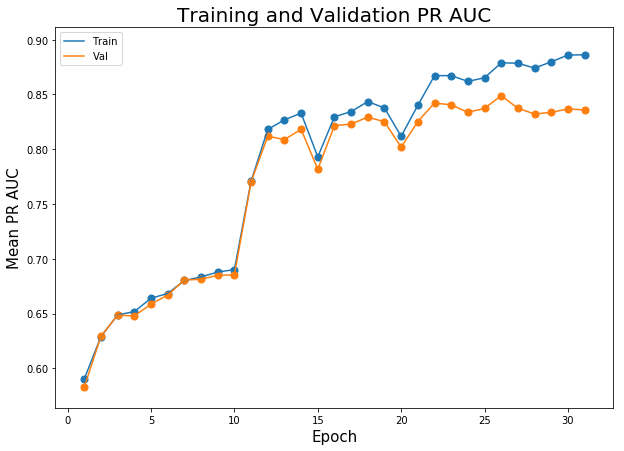

In [37]:
pr_auc_history_train = train_metric_callback.get_pr_auc_history()
pr_auc_history_val = val_callback.get_pr_auc_history()

plt.figure(figsize=(10, 7))
plot_with_dots(plt, pr_auc_history_train[-1])
plot_with_dots(plt, pr_auc_history_val[-1])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean PR AUC', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation PR AUC', fontsize=20)
plt.savefig('pr_auc_hist.png')

In [ ]:
plt.figure(figsize=(10, 7))
plot_with_dots(plt, history_0.history['loss']+history_1.history['loss'])
plot_with_dots(plt, history_0.history['val_loss']+history_1.history['val_loss'])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Binary Crossentropy', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation Loss', fontsize=20)
plt.savefig('loss_hist.png')

I left the model to train longer on my local GPU. I then upload the best model and plots from the model training.

In [ ]:
#model = load_model('../input/clouds-classifier-files/classifier_densenet169_epoch_21_val_pr_auc_0.8365921057512743.h5')

In [ ]:
Image("../input/clouds-classifier-files/loss_hist_densenet169.png")

In [ ]:
Image("../input/clouds-classifier-files/pr_auc_hist_densenet169.png")

# Selecting postprocessing thresholds

In [ ]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def get_threshold_for_recall(y_true, y_pred, class_i, recall_threshold=0.94, precision_threshold=0.90, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
    i = len(thresholds) - 1
    best_recall_threshold = None
    while best_recall_threshold is None:
        next_threshold = thresholds[i]
        next_recall = recall[i]
        if next_recall >= recall_threshold:
            best_recall_threshold = next_threshold
        i -= 1
        
    # consice, even though unnecessary passing through all the values
    best_precision_threshold = [thres for prec, thres in zip(precision, thresholds) if prec >= precision_threshold][0]
    
    if plot:
        plt.figure(figsize=(10, 7))
        plt.step(recall, precision, color='r', alpha=0.3, where='post')
        plt.fill_between(recall, precision, alpha=0.3, color='r')
        plt.axhline(y=precision[i + 1])
        recall_for_prec_thres = [rec for rec, thres in zip(recall, thresholds) 
                                 if thres == best_precision_threshold][0]
        plt.axvline(x=recall_for_prec_thres, color='g')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(['PR curve', 
                    f'Precision {precision[i + 1]: .2f} corresponding to selected recall threshold',
                    f'Recall {recall_for_prec_thres: .2f} corresponding to selected precision threshold'])
        plt.title(f'Precision-Recall curve for Class {class_names[class_i]}')
    return best_recall_threshold, best_precision_threshold

y_pred = model.predict_generator(data_generator_val, workers=num_cores)
y_true = data_generator_val.get_labels()
recall_thresholds = dict()
precision_thresholds = dict()
for i, class_name in tqdm(enumerate(class_names)):
    recall_thresholds[class_name], precision_thresholds[class_name] = get_threshold_for_recall(y_true, y_pred, i, plot=True)

# Post-processing segmentation submission

Predicting cloud classes for test.

In [ ]:
data_generator_test = DataGenenerator(folder_imgs=test_imgs_folder, shuffle=False)
y_pred_test = model.predict_generator(data_generator_test, workers=num_cores)

Estimating set of images without masks.

In [ ]:
image_labels_empty = set()
for i, (img, predictions) in enumerate(zip(os.listdir(test_imgs_folder), y_pred_test)):
    for class_i, class_name in enumerate(class_names):
        if predictions[class_i] < recall_thresholds[class_name]:
            image_labels_empty.add(f'{img}_{class_name}')

Segmentation results:

In [ ]:
submission = pd.read_csv('../input/densenet201cloudy/densenet201.csv')
submission.head()

In [ ]:
predictions_nonempty = set(submission.loc[~submission['EncodedPixels'].isnull(), 'Image_Label'].values)

In [ ]:
print(f'{len(image_labels_empty.intersection(predictions_nonempty))} masks would be removed')

In [ ]:
#removing masks
submission.loc[submission['Image_Label'].isin(image_labels_empty), 'EncodedPixels'] = np.nan
submission.to_csv('submission_segmentation_and_classifier.csv', index=None)

# Future work
1. estimate distribution of classes in test set using the classifier. Then, if necessary and doable, modify val set accordingly,
2. use the classifier with explainability technique [Gradient-weighted Class Activation Mapping](http://gradcam.cloudcv.org/) to generate a baseline, (please see [GradCAM: extracting masks from classifier](https://www.kaggle.com/samusram/gradcam-extracting-masks-from-classifier)),
3. improve the classifier,
4. use the classifier as backbone for UNet-like solution.